# Project 3 - Thermal inspection (classifying the defects) of photovoltaic modules

## Assignment 2

**Computer Vision**

Master in Data Science and Engineering - Faculdade de Engenharia da Universidade do Porto


Cátia Teixeira (200808037) |  Miguel Veloso (202202463)



---



## Introduction

The use of renewable energies has been on the rise in recent years, and one of the energy sources that stands out 
of this trend is solar energy, especially in countries where there is an abundance of sunlight.
As demand for solar energy increases, maintenance tasks naturally arise, which in some cases can be quite complex. In this particular case, in solar energy, the monitoring of the state of photovoltaic cells is done through photos, which are then manually classified according to the type of damage or disturbance to the cell - both of which have an impact on the ability to produce solar energy. One approach to make this maintenance more autonomous is through the use of Machine Learning or Deep Learning techniques, in which these algorithms automatically classify the type of damage or disturbance affecting a given cell.

The following classes are present in our dataset:



1.  **Cell Module**: a hot spot that appears in a single cell
2.   **Cell-Multi Module**: one of the hot spots in multiple cells
3.   **Cracking**: appeared on the surface of the module in single or multiple long-curve
4.    **Diode module**: activated bypass diode in about 1/3 area of the
module, which looks like a straight line in the IR image
5.   **Diode-Multi module**: activated bypass diode in about 2/3 area of the module
6.   **Hot-Spot module**: hot-spot in a thin film module
7. **Hot-Spot-Multi module**: multiple hot-spot in the thin-film module
8. **Offline module**: s heated entire the module (which looks like the No-anomaly module)
9. **Shadowing module**: blocked by vegetation or manmade structure
10. **Vegetation module**: blocked by vegetation (which is similar to the Shadowing module)
11. **Soiling module**: dirt or dust on the surface of the module (which looks like the Cell or Vegetation modules in the IR image)
12. **No-anomaly module**: Nominal solar module

There are 20,000 images with 40 × 24 pixels of each, and the no-anomaly images are half of it (10,000 images). Not only we have one class with half of the dataset but there is also 4 classes with less than 300 images, which is very short specially after splitting the dataset in train, validation and test (it will be mentioned later). Having in mind the previous, we were aware that it was going to be particularly challenging to get the models to learn to classify correctly.
The project is based on the article by Minhhuy Le, DucVu Le and Ha Thi Vu entitled "Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in AUV", in which they use a CNN model with data augmentation in the training images to detect anomalies. We presented a similar CNN, but slightly more complex (among other additions, we included dropout to deal with the overfitting issues). The dataset was divide in Train, Validation and Test with the proportions of (80/10/10), and we used the validation mainly to check for overfitting signs. Since the dataset is unbalanced, we used three techniques to deal with this issue, the first one was throught data augmentation, were it artificially increases the size of a dataset by applying various transformations to the existing data, then we used the class sensitive learning, that uses the different weights according with the number of samples of each class, classes with higher number of samples will receive a small weight whilist a class with a lower number of samples will receive a heigher weight. We would like to highlight the use of Generative Adversarial Network (GAN's) for balancing the dataset, in which realistic images artificially created by this model are generated for each of the classes, with the aim of combine these syntetic images with real images to training the model with these new images.
In addition to CNN, we also experimented with different types of pre-trained models, such as ResNet18, MobileNet and a VisualTransformer. These pre-trained models required a great deal of computing power, as was expected, even with most of their parameters frozen.
The following metrics were used to evaluate the results of all these models/experiences: Confusion Matrix, F1 Score, AUC and Accuracy.
The confusion matrix is essencial for an unbalanced dataset as it offers a comprehensive view of a model's strengths and weaknesses, aiding in the identification of specific error patterns and areas for improvement. The the F1 Score combines precision and recall into a single value, with higher scores indicating better overall model performance.






---



## Methodology

In the following diagram we can see the proposed plan for this project.

<center><img src="flow_final.png"/></center>

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torchinfo import summary
from torch.optim import Adam
import cv2
import numpy as np
from PIL import Image

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print ("Device is:", device)

Device is: cuda


In [3]:
import utils

In [5]:
import scprep
scprep.io.download.download_and_extract_zip(
   url="https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip",
   destination=".")

In [4]:
metadata_path = "./InfraredSolarModules/module_metadata.json"
images_path = "./InfraredSolarModules/"
solar_dataset = utils.SolarDataset(metadata_path, images_path, random_state=42)

(20000, 2)


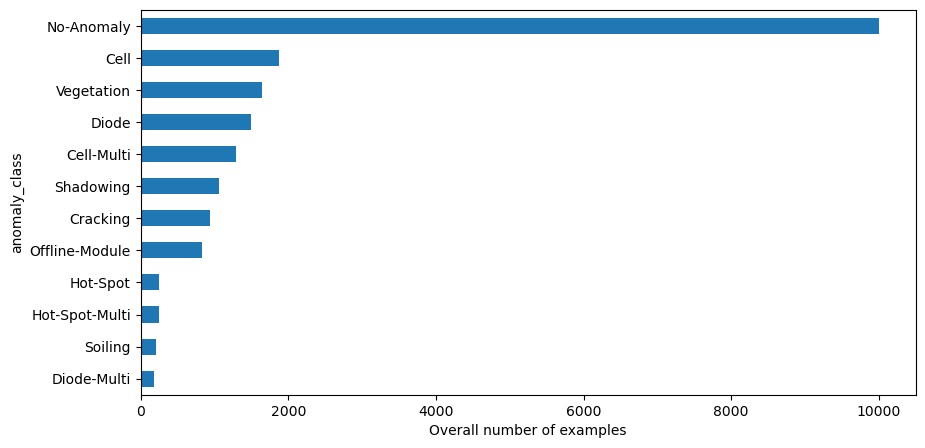

(12801, 2)


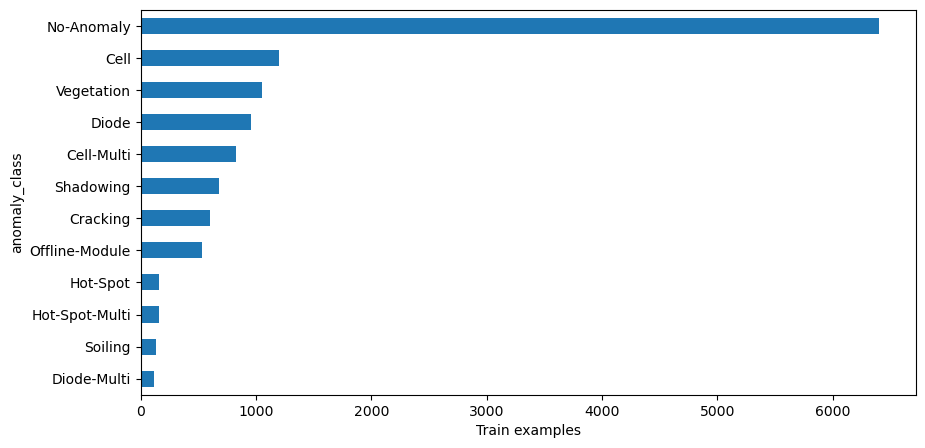

(3199, 2)


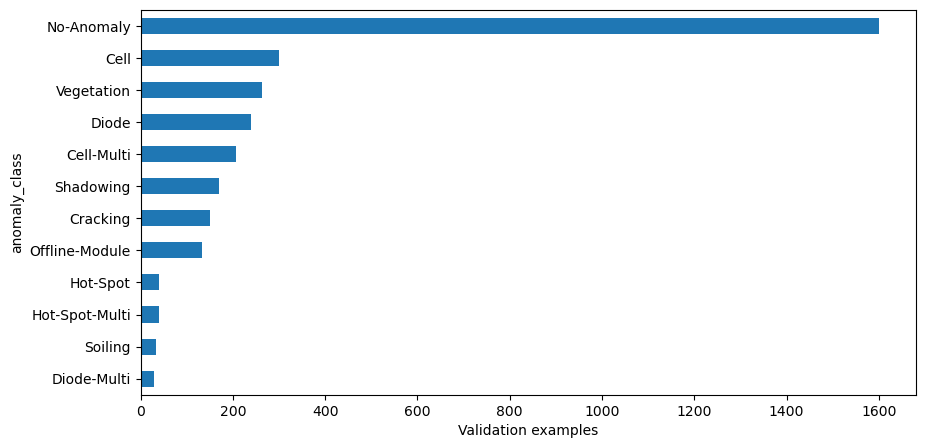

(4000, 2)


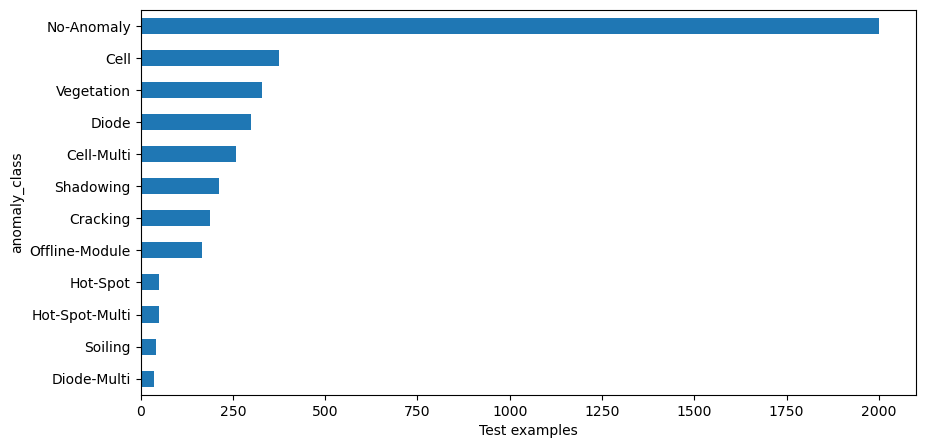

In [5]:
dfs_to_show = [
    [solar_dataset.full_df, "Overall number of examples"],
    [solar_dataset.train_df, "Train examples"],
    [solar_dataset.val_df, "Validation examples"],
    [solar_dataset.test_df, "Test examples"],
]

for (d, t) in dfs_to_show:
    ax = d.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
    ax.set_xlabel(t)
    print(d.shape)
    plt.show()

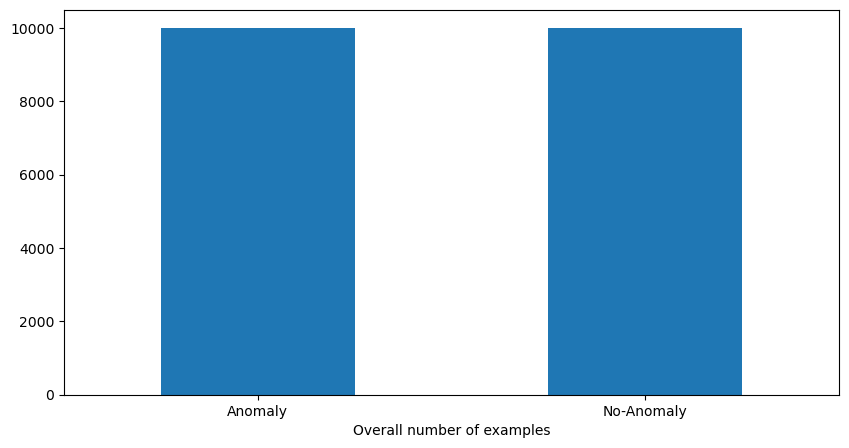

In [6]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

df_binary = solar_dataset.full_df.copy()
df_binary['anomaly_class'] = solar_dataset.full_df.anomaly_class.apply(convert_to_binary)
ax = df_binary['anomaly_class'].value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.set_xlabel('Overall number of examples')
plt.show()

# Basic Pre-Processing

In [7]:
def preprocess_none(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[np.newaxis]
    return [image]

In [8]:
def preprocess_basic(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    transforms_list = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
    ]

    image = transforms_list[0](Image.fromarray(image)).numpy()
    return [image]

# Defining Model from Paper

In [9]:
class PaperClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            # BLock 1
            nn.Conv2d(in_dim[0], 80, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(80),
            # Block 2
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(160),
            # Block 3
            nn.Conv2d(160, 320, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(320),
            # Block 4
            nn.Conv2d(320, 640, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 2),
            nn.BatchNorm2d(640),
            # Average Pool
            nn.AvgPool2d(2),
            # Fully connected
            nn.Flatten(),
            nn.Linear(640, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

## Running model from paper

In [227]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
paper_model = PaperClassificator(input_dim, output_dim).to(device)
print(summary(paper_model, (1, input_dim[0], input_dim[1], input_dim[2])))
paper_loss = torch.nn.CrossEntropyLoss()
paper_optimizer = Adam(paper_model.parameters(), lr=0.0003)
paper_train_test = utils.TrainTest(
    paper_model,
    paper_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_none,
)

Layer (type:depth-idx)                   Output Shape              Param #
PaperClassificator                       [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

Loss = 2.0149195061789618   Accuracy= 0.6071428571428571
Best Epoch # 0  Validation Loss= 2.0149195061789618  Validation Accu= 0.6071428571428571
Loss = 1.971483380075485   Accuracy= 0.6480654761904762
Best Epoch # 1  Validation Loss= 1.971483380075485  Validation Accu= 0.6480654761904762
Loss = 1.9582862835081796   Accuracy= 0.6644345238095238
Best Epoch # 2  Validation Loss= 1.9582862835081796  Validation Accu= 0.6644345238095238
Loss = 1.9467497363923087   Accuracy= 0.669890873015873
Best Epoch # 3  Validation Loss= 1.9467497363923087  Validation Accu= 0.669890873015873
Loss = 1.9481919890358335   Accuracy= 0.6686507936507936
Loss = 1.9271904040896704   Accuracy= 0.6912202380952381
Best Epoch # 5  Validation Loss= 1.9271904040896704  Validation Accu= 0.6912202380952381
Loss = 1.9217007652161613   Accuracy= 0.6959325396825397
Best Epoch # 6  Validation Loss= 1.9217007652161613  Validation Accu= 0.6959325396825397
Loss = 1.9481198976910303   Accuracy= 0.6671626984126984
Loss = 1.91715

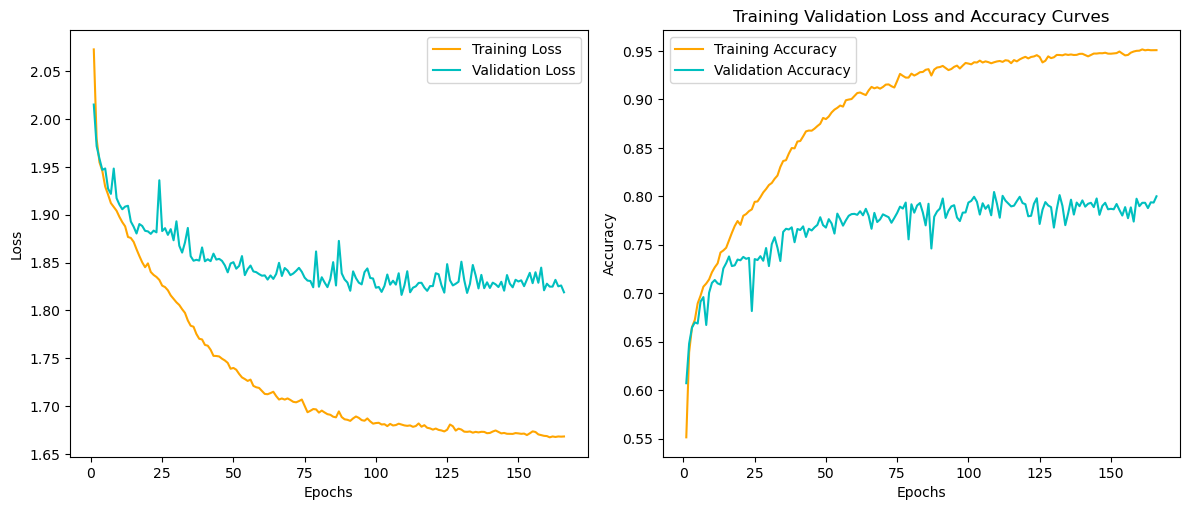

In [228]:
# Train Model
paper_best_loss, paper_best_accuracy, paper_best_epoch = paper_train_test.train(paper_optimizer, 166, "paper_model.pth")

Loss = 1.818983653235057   Accuracy= 0.7998511904761905


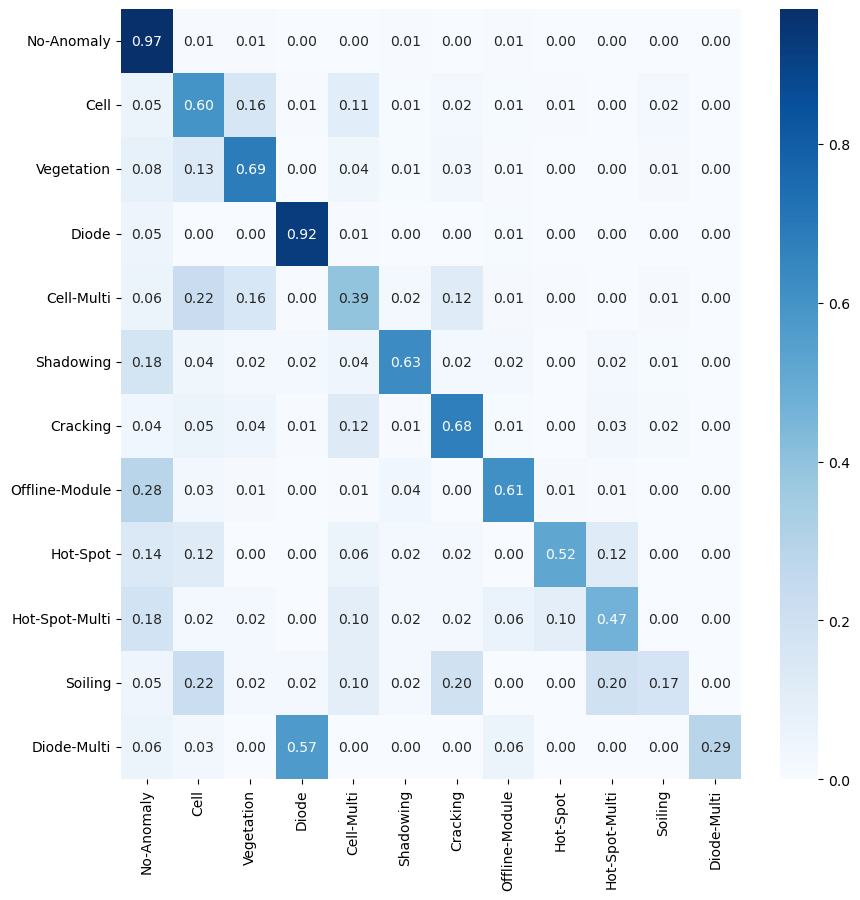

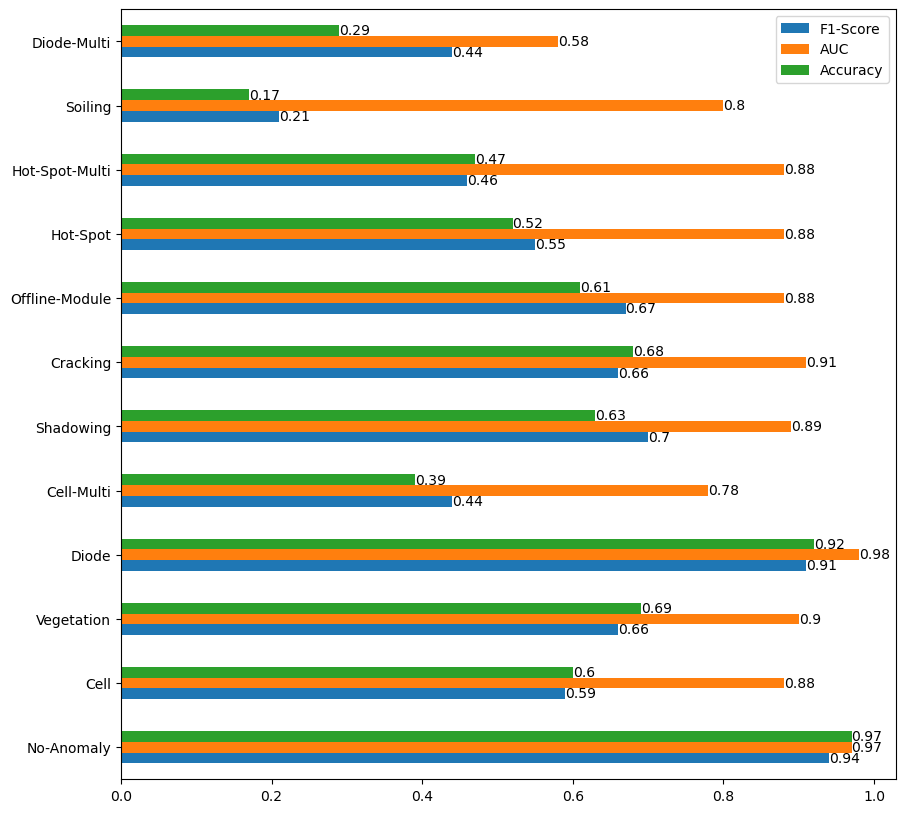

In [229]:
paper_train_test.test()
paper_train_test.plot_confusion_matrix()
paper_train_test.plot_class_metrics()

---

# Defining our CNN model

In [11]:
class OurClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_dim[0], 25, 4, 1, 1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.Dropout(0.30),
            #
            nn.Conv2d(25, 50, 4, 1, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # Downsample
            nn.Dropout(0.30),
            #
            nn.Conv2d(50, 75, 3, 1, 1),
            nn.BatchNorm2d(75),
            nn.ReLU(),
            nn.Dropout(0.30),
            #
            nn.Conv2d(75, 100, 3, 1, 1),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # Downsample
            nn.Dropout(0.30),
            #
            nn.Conv2d(100, 125, 3, 1, 1),
            nn.BatchNorm2d(125),
            nn.ReLU(),
            nn.Dropout(0.30),
            #
            nn.Conv2d(125, 150, 3, 1, 1),
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # Downsample
            nn.Dropout(0.30),
            #
            nn.Conv2d(150, 175, 3, 1, 1),
            nn.BatchNorm2d(175),
            nn.ReLU(),
            nn.Dropout(0.30),
            #
            nn.Conv2d(175, 200, 3, 1, 1),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.30),
            #
            nn.Flatten(),
            nn.Linear(400, 100),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(100, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

In [12]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss = nn.CrossEntropyLoss().to(device)
our_optimizer = Adam(our_model.parameters(), lr=0.000127)
our_train_test = utils.TrainTest(
    our_model,
    our_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 25, 39, 23]           425
│    └─BatchNorm2d: 2-2                  [1, 25, 39, 23]           50
│    └─ReLU: 2-3                         [1, 25, 39, 23]           --
│    └─Dropout: 2-4                      [1, 25, 39, 23]           --
│    └─Conv2d: 2-5                       [1, 50, 38, 22]           20,050
│    └─BatchNorm2d: 2-6                  [1, 50, 38, 22]           100
│    └─ReLU: 2-7                         [1, 50, 38, 22]           --
│    └─AvgPool2d: 2-8                    [1, 50, 19, 11]           --
│    └─Dropout: 2-9                      [1, 50, 19, 11]           --
│    └─Conv2d: 2-10                      [1, 75, 19, 11]           33,825
│    └─BatchNorm2d: 2-11                 [1, 75, 19, 11]           150
│   

Loss = 2.1147605502416216   Accuracy= 0.503968253968254
Best Epoch # 0  Validation Loss= 2.1147605502416216  Validation Accu= 0.503968253968254
Loss = 2.114743616845873   Accuracy= 0.503968253968254
Loss = 2.1119442232071406   Accuracy= 0.503968253968254
Loss = 2.0660341883462574   Accuracy= 0.5528273809523809
Best Epoch # 3  Validation Loss= 2.0660341883462574  Validation Accu= 0.5528273809523809
Loss = 2.060517014019073   Accuracy= 0.5570436507936508
Best Epoch # 4  Validation Loss= 2.060517014019073  Validation Accu= 0.5570436507936508
Loss = 2.038423659309508   Accuracy= 0.5786210317460317
Best Epoch # 5  Validation Loss= 2.038423659309508  Validation Accu= 0.5786210317460317
Loss = 2.0184760831651234   Accuracy= 0.5964781746031746
Best Epoch # 6  Validation Loss= 2.0184760831651234  Validation Accu= 0.5964781746031746
Loss = 1.9801152774265833   Accuracy= 0.6371527777777778
Best Epoch # 7  Validation Loss= 1.9801152774265833  Validation Accu= 0.6371527777777778
Loss = 1.9807636737

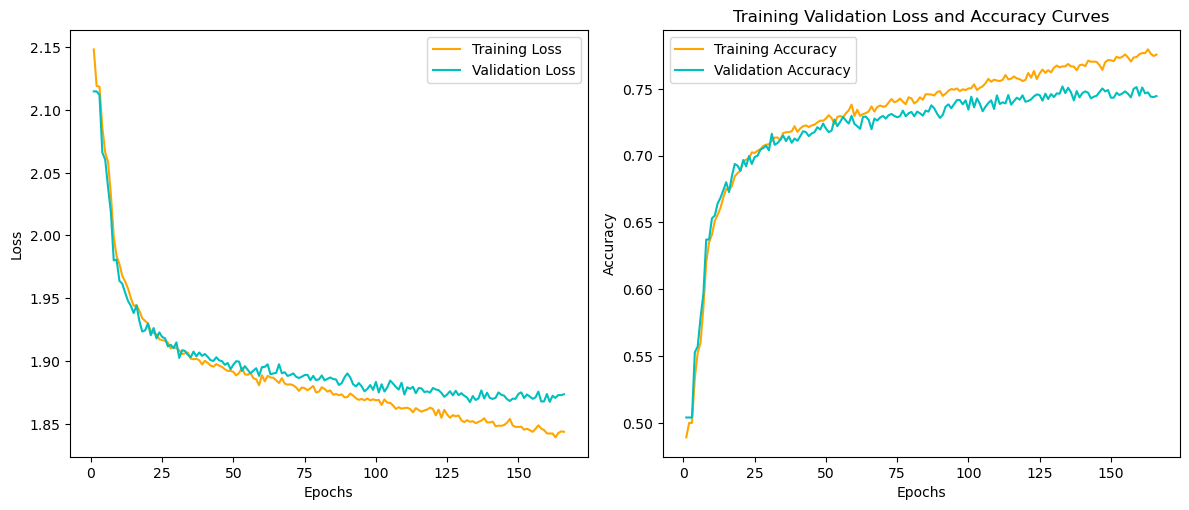

In [13]:
# Train Model
our_best_loss, our_best_accuracy, our_best_epoch = our_train_test.train(our_optimizer, 166, "our_model.pth")

Loss = 1.873503811775692   Accuracy= 0.7445436507936508


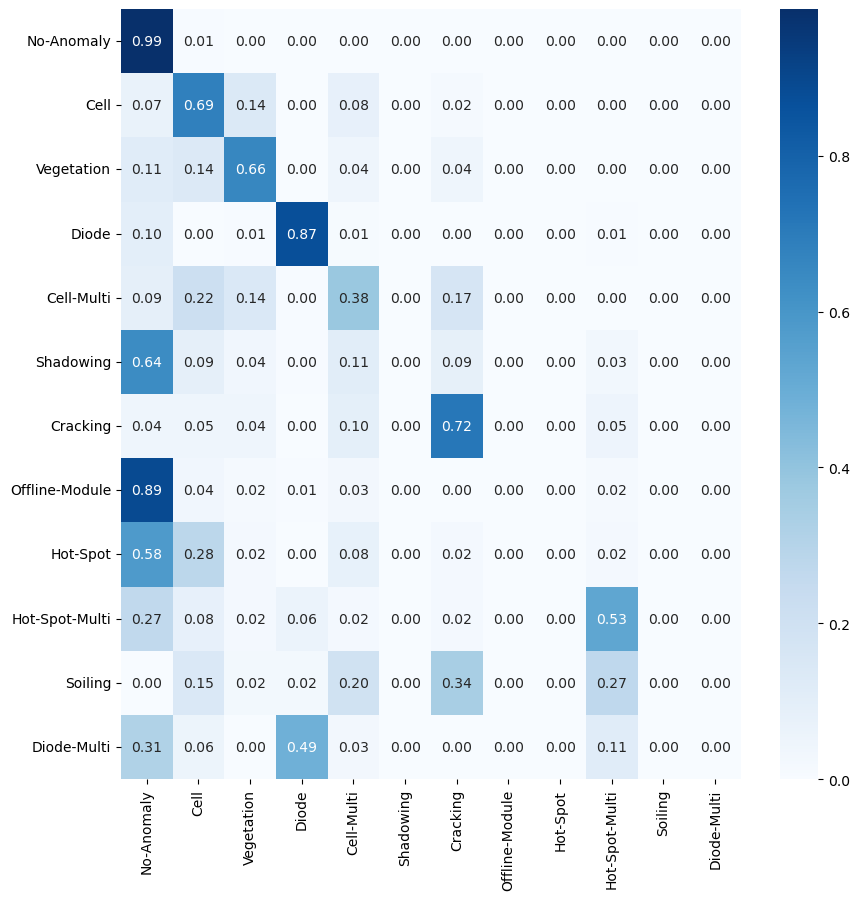

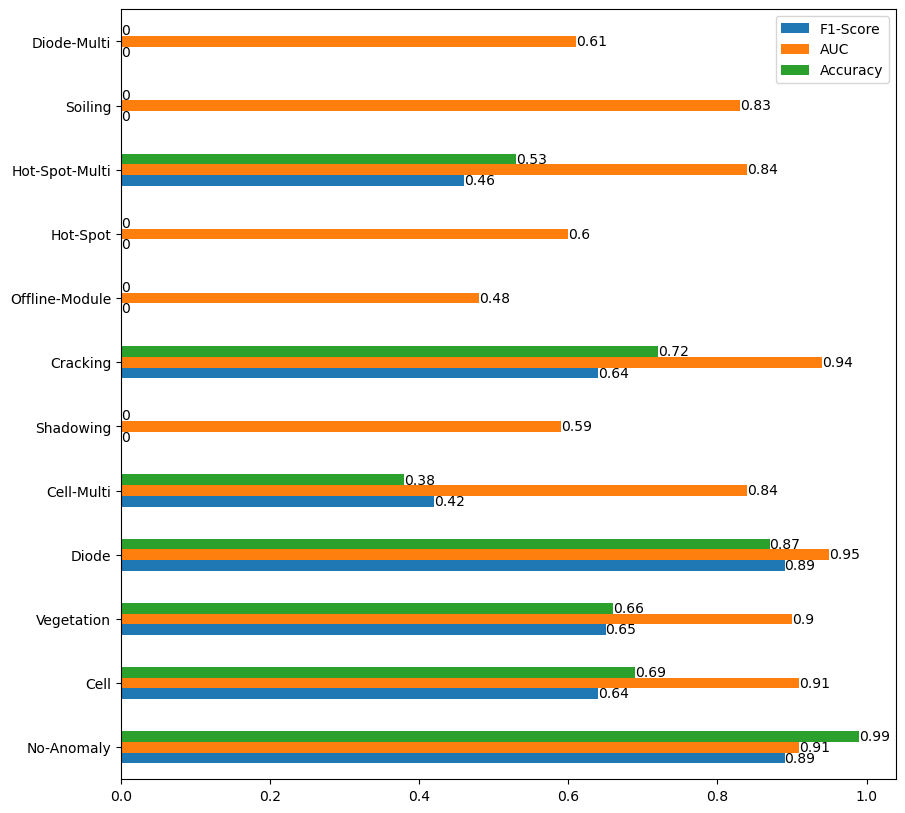

In [14]:
our_train_test.test()
our_train_test.plot_confusion_matrix()
our_train_test.plot_class_metrics()

---

# Adding Class Sensitive Learning (Condition B)

In [15]:
total_imgs = len(solar_dataset.train_df)
class_weights = np.zeros(solar_dataset.num_classes)
for k, v in dict(solar_dataset.train_df.anomaly_class.value_counts()).items():
    class_weights[solar_dataset.classes_list.index(k)] = v
class_weights = torch.tensor([total_imgs/(class_imgs*solar_dataset.num_classes) for class_imgs in class_weights]).to(device)
print(class_weights)
print(solar_dataset.classes_list)

tensor([0.1667, 0.8875, 1.0169, 1.1124, 1.2946, 1.5780, 1.7720, 2.0127, 6.7091,
        6.7516, 8.2058, 9.5246], device='cuda:0', dtype=torch.float64)
['No-Anomaly', 'Cell', 'Vegetation', 'Diode', 'Cell-Multi', 'Shadowing', 'Cracking', 'Offline-Module', 'Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi']


In [16]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_w = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_w, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_w = nn.CrossEntropyLoss(weight=class_weights)
our_optimizer_w = Adam(our_model_w.parameters(), lr=0.000127)
our_train_test_w = utils.TrainTest(
    our_model_w,
    our_loss_w,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 25, 39, 23]           425
│    └─BatchNorm2d: 2-2                  [1, 25, 39, 23]           50
│    └─ReLU: 2-3                         [1, 25, 39, 23]           --
│    └─Dropout: 2-4                      [1, 25, 39, 23]           --
│    └─Conv2d: 2-5                       [1, 50, 38, 22]           20,050
│    └─BatchNorm2d: 2-6                  [1, 50, 38, 22]           100
│    └─ReLU: 2-7                         [1, 50, 38, 22]           --
│    └─AvgPool2d: 2-8                    [1, 50, 19, 11]           --
│    └─Dropout: 2-9                      [1, 50, 19, 11]           --
│    └─Conv2d: 2-10                      [1, 75, 19, 11]           33,825
│    └─BatchNorm2d: 2-11                 [1, 75, 19, 11]           150
│   

Loss = 2.4280953056167194   Accuracy= 0.0689484126984127
Best Epoch # 0  Validation Loss= 2.4280953056167194  Validation Accu= 0.0689484126984127
Loss = 2.362079530579551   Accuracy= 0.10466269841269842
Best Epoch # 1  Validation Loss= 2.362079530579551  Validation Accu= 0.10466269841269842
Loss = 2.307569104242462   Accuracy= 0.1111111111111111
Best Epoch # 2  Validation Loss= 2.307569104242462  Validation Accu= 0.1111111111111111
Loss = 2.2657852383086716   Accuracy= 0.12698412698412698
Best Epoch # 3  Validation Loss= 2.2657852383086716  Validation Accu= 0.12698412698412698
Loss = 2.241872554225673   Accuracy= 0.14856150793650794
Best Epoch # 4  Validation Loss= 2.241872554225673  Validation Accu= 0.14856150793650794
Loss = 2.2189250150638875   Accuracy= 0.251984126984127
Best Epoch # 5  Validation Loss= 2.2189250150638875  Validation Accu= 0.251984126984127
Loss = 2.1716533140202676   Accuracy= 0.4494047619047619
Best Epoch # 6  Validation Loss= 2.1716533140202676  Validation Accu=

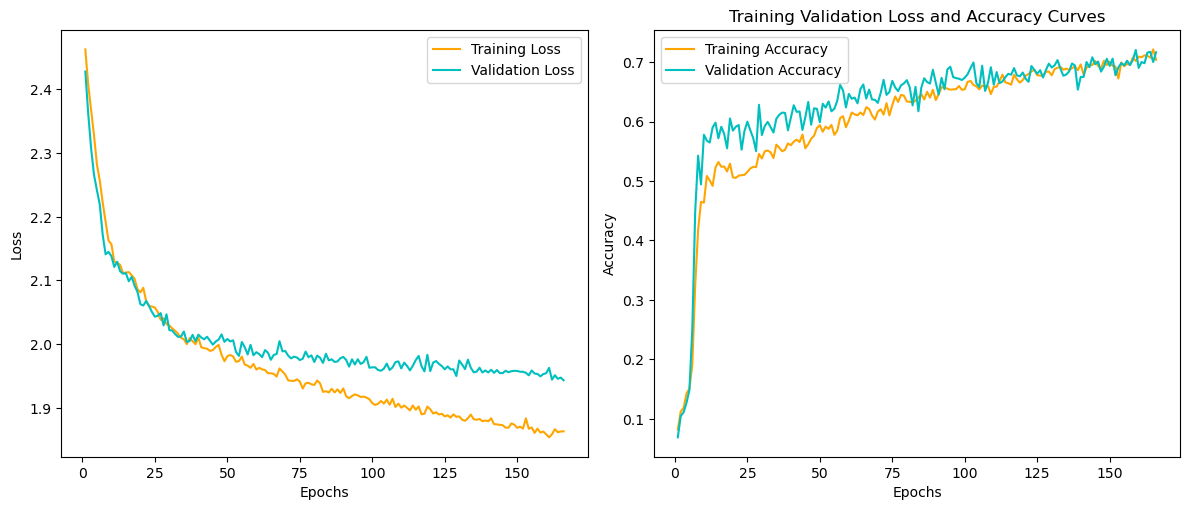

In [17]:
# Train Model
our_best_w_loss, our_best_w_accuracy, our_best_w_epoch = our_train_test_w.train(our_optimizer_w, 166, "our_model_w.pth")

Loss = 1.9432469961307455   Accuracy= 0.7165178571428571


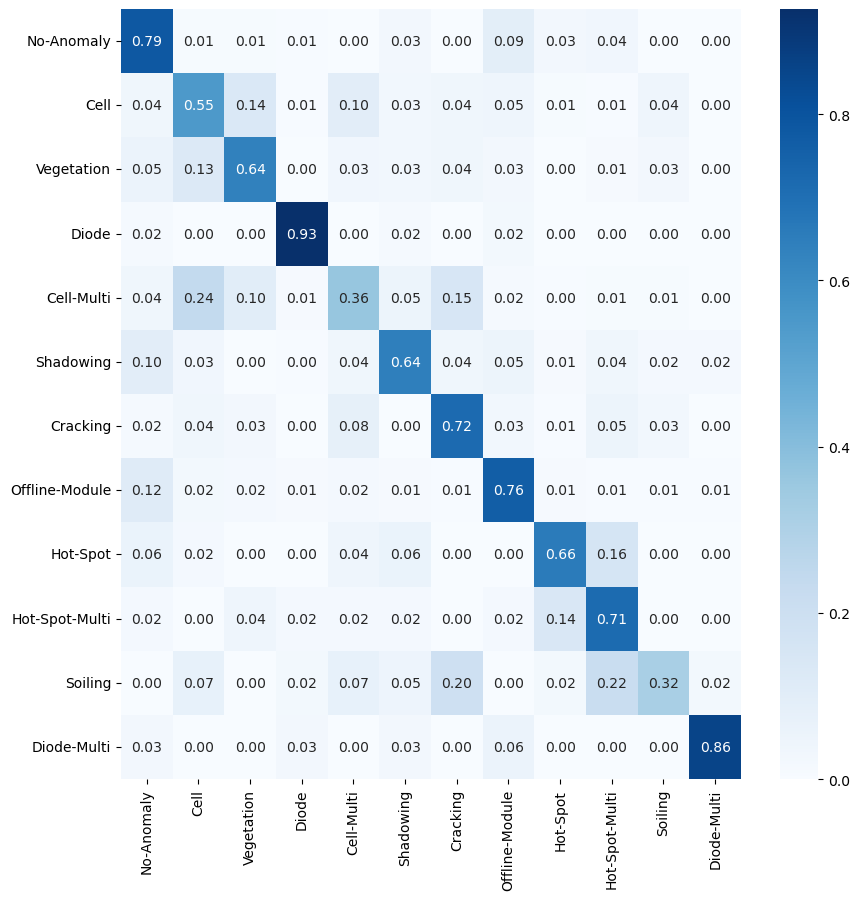

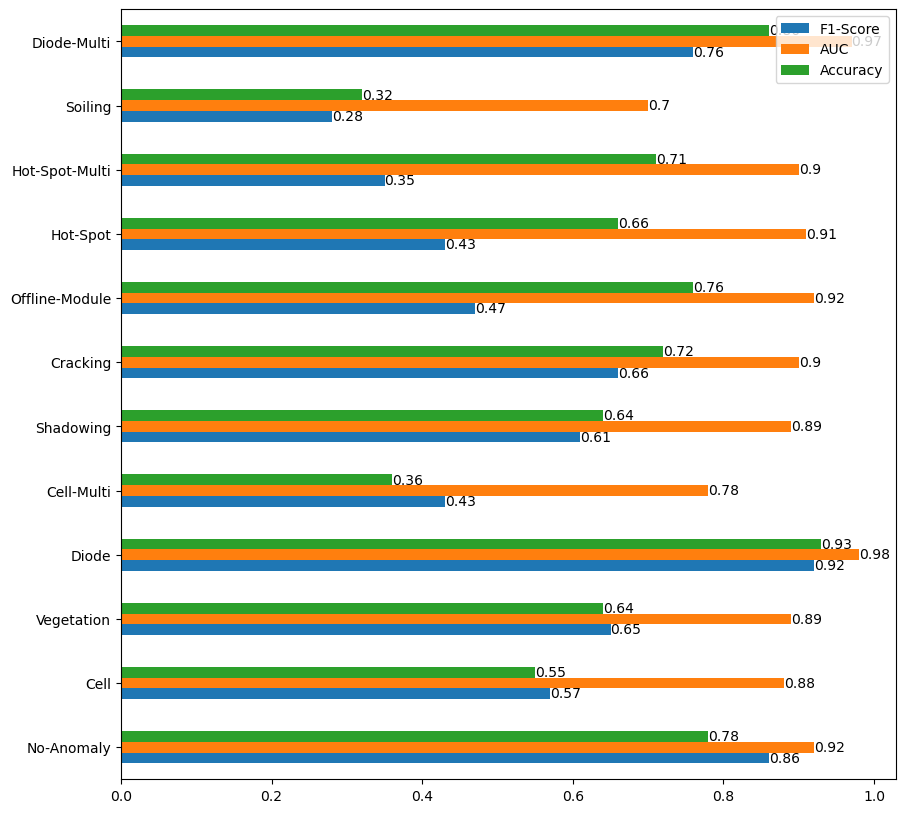

In [18]:
our_train_test_w.test()
our_train_test_w.plot_confusion_matrix()
our_train_test_w.plot_class_metrics()

---

# Adding Data Augmentation (Condition C)

### Traditional data augmentation techniques

We first start with our baseline model, without using any data augmentation, however and since our dataset is relatively small, speacially if we consider that half of the dataset is only for one class (10000 samples for Non Anomaly Class), we decided to do some experiments with data augmentation.
Applying data augmentation usually provide better results since it increases the training set size by generating additional training samples by applying transformations such as rotation, flipping, scaling, and cropping to the original images. This increases the diversity of the dataset, which can be particularly beneficial when working with limited labeled data.

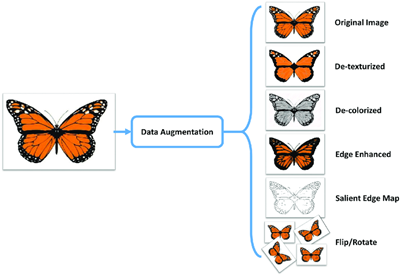

Below a few types of transformations were defined, some had more success than others (increasing or decreasing the model accuracy).
<br><br>


**RandomHorizontalFlip**(p) : Horizontally flip the given PIL Image randomly with a given probability p

**RandomVertitalFlip**(p) : Vertitally flip the given PIL Image randomly with a given probability p

The following technique were experimented and later removed since we found no improvements:

**ColorJitter**(brightness=0, contrast=0, saturation=0, hue=0) :
Randomly change the brightness, contrast and saturation of an image.
The parameters describe how much to jitter 

**RandomRotation**(degrees) : Rotate the image by angle.   
degrees : Range of degrees to select from. If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).



In [24]:
def preprocess_augment(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomApply(transforms=[
                transforms.RandomHorizontalFlip(p=0.30),
                transforms.RandomVerticalFlip(p=0.30),
            ]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [25]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_aug = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_aug, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_aug = nn.CrossEntropyLoss()
our_optimizer_aug = Adam(our_model_aug.parameters(), lr=0.000127)
our_train_test_aug = utils.TrainTest(
    our_model_aug,
    our_loss_aug,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_augment,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 25, 39, 23]           425
│    └─BatchNorm2d: 2-2                  [1, 25, 39, 23]           50
│    └─ReLU: 2-3                         [1, 25, 39, 23]           --
│    └─Dropout: 2-4                      [1, 25, 39, 23]           --
│    └─Conv2d: 2-5                       [1, 50, 38, 22]           20,050
│    └─BatchNorm2d: 2-6                  [1, 50, 38, 22]           100
│    └─ReLU: 2-7                         [1, 50, 38, 22]           --
│    └─AvgPool2d: 2-8                    [1, 50, 19, 11]           --
│    └─Dropout: 2-9                      [1, 50, 19, 11]           --
│    └─Conv2d: 2-10                      [1, 75, 19, 11]           33,825
│    └─BatchNorm2d: 2-11                 [1, 75, 19, 11]           150
│   

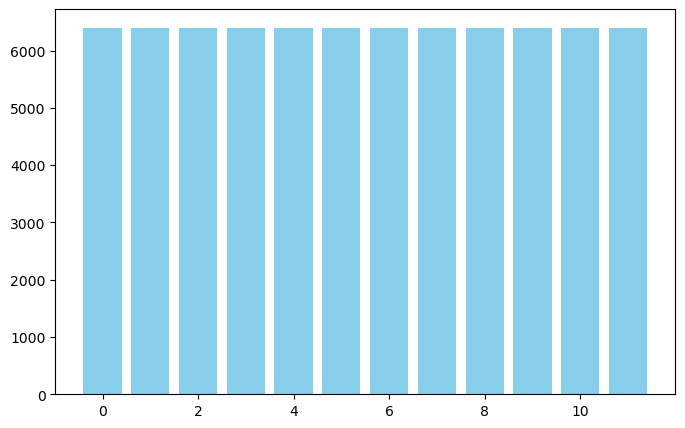

6400 6400


In [26]:
labels = []
for _, target in our_train_test_aug.train_dataloader:
    labels.extend(target.numpy())

counts = {}
for l in labels:
    if l not in counts:
        counts[l] = 0
    counts[l] += 1

class_l = list(counts.keys())
counts = list(counts.values())

plt.figure(figsize=(8,5))
plt.bar(class_l, counts, color="skyblue")
plt.show()

print(np.max(counts), np.min(counts))

Loss = 2.0798048343658446   Accuracy= 0.53425
Best Epoch # 0  Validation Loss= 2.0798048343658446  Validation Accu= 0.53425
Loss = 2.012981897354126   Accuracy= 0.60225
Best Epoch # 1  Validation Loss= 2.012981897354126  Validation Accu= 0.60225
Loss = 1.9671358032226562   Accuracy= 0.65025
Best Epoch # 2  Validation Loss= 1.9671358032226562  Validation Accu= 0.65025
Loss = 1.9679905042648316   Accuracy= 0.6495
Loss = 1.9587301712036134   Accuracy= 0.6575
Best Epoch # 4  Validation Loss= 1.9587301712036134  Validation Accu= 0.6575
Loss = 1.9731764678955077   Accuracy= 0.64525
Loss = 1.928173448562622   Accuracy= 0.68825
Best Epoch # 6  Validation Loss= 1.928173448562622  Validation Accu= 0.68825
Loss = 1.9184666891098023   Accuracy= 0.699
Best Epoch # 7  Validation Loss= 1.9184666891098023  Validation Accu= 0.699
Loss = 1.934389931678772   Accuracy= 0.6825
Loss = 1.914909426689148   Accuracy= 0.704
Best Epoch # 9  Validation Loss= 1.914909426689148  Validation Accu= 0.704
Loss = 1.9237

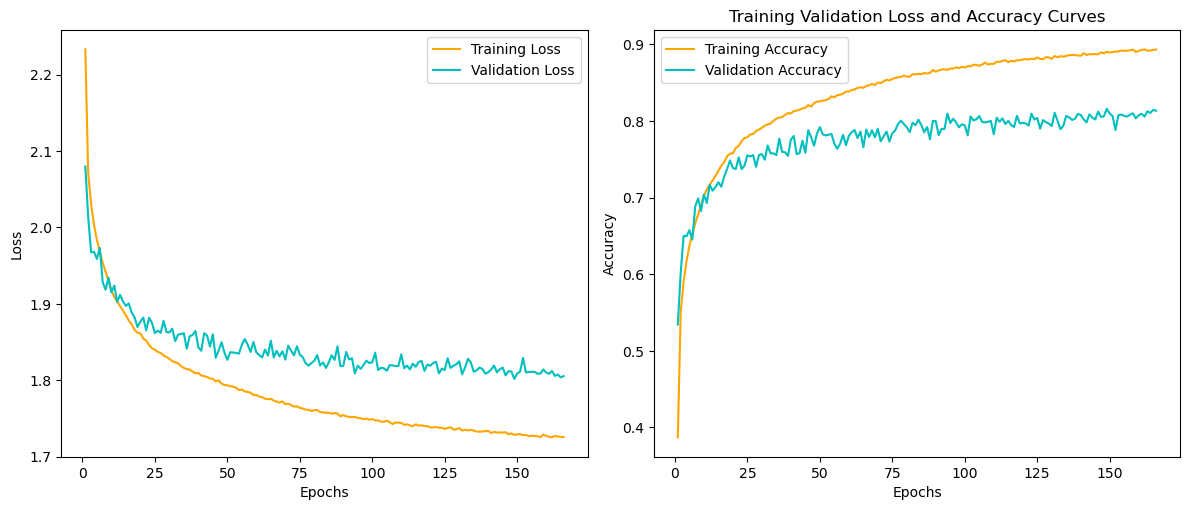

In [27]:
# Train Model
our_best_aug_loss, our_best_aug_accuracy, our_best_aug_epoch = our_train_test_aug.train(our_optimizer_aug, 166, "our_model_aug.pth")

Loss = 1.8054161443710328   Accuracy= 0.8135


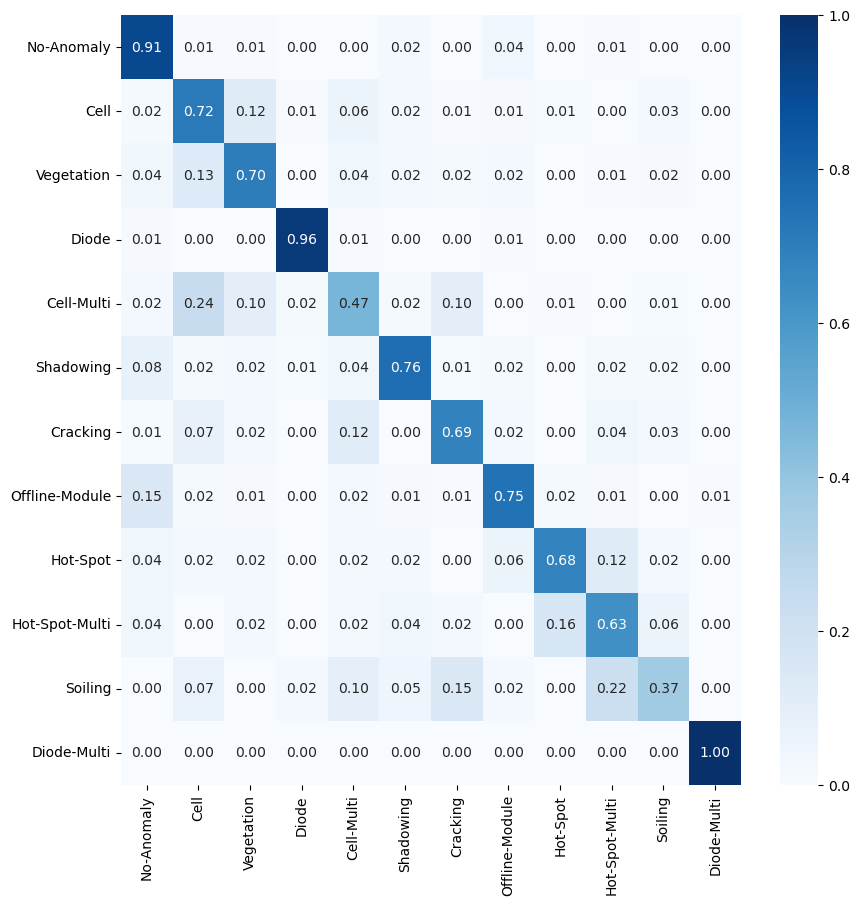

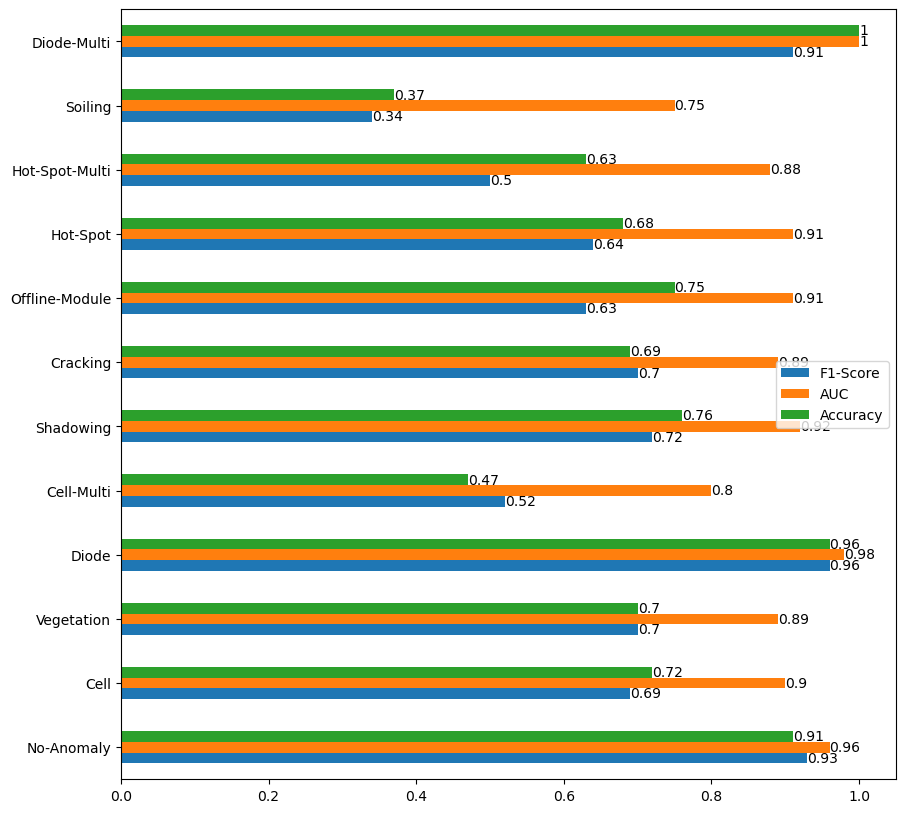

In [28]:
our_train_test_aug.test()
our_train_test_aug.plot_confusion_matrix()
our_train_test_aug.plot_class_metrics()

---

# Data Augmentation (Condition D)

Using GAN's for Data Augmentation

In [29]:
def preprocess_gan(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    transforms_list = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
    ]

    image = transforms_list[0](Image.fromarray(image)).numpy()
    return [image]

In [30]:
class GAugmented(nn.Module):
    def __init__(self, img_shape, solar_dataset, latent_dim=100, features_gen=20, features_disc=20):
        super().__init__()
        self.img_size = img_shape[0] * img_shape[1] * img_shape[2]
        self.features_gen = features_gen
        self.features_disc = features_disc
        self.generator = self.Generator(latent_dim, img_shape, img_shape[0], features_gen, solar_dataset.num_classes).to(device)
        self.generator.weight_init(mean=0.0, std=0.02)
        self.discriminator = self.Discriminator(img_shape[0], features_disc, solar_dataset.num_classes).to(device)
        self.discriminator.weight_init(mean=0.0, std=0.02)
        self.lr_gen = 0.0002
        self.lr_disc = 0.0002
        self.batch_size = 128
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.solar_dataset = solar_dataset

        print(summary(self.generator,
                [(1, latent_dim, 1, 1), (1, solar_dataset.num_classes, 1, 1)]))
        print(summary(self.discriminator,
                [(1, img_shape[0], img_shape[1], img_shape[2]),
                 (1, solar_dataset.num_classes, img_shape[1], img_shape[2])]))

        # Optimizers and loss function
        beta1 = 0.50
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr_gen, betas=(beta1, 0.999))
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_disc, betas=(beta1, 0.999))
        self.adversarial_loss = nn.BCELoss()

        # One hot encoded labels
        self.fill_d = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, img_shape[1], img_shape[2]]).to(device)
        self.fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
        for i in range(self.solar_dataset.num_classes):
            self.fill_d[i, i, :, :] = 1
            self.fill_g[i, i, :, :] = 1

    def fit(self, dataloader, epochs=500):
        fit_total_loss_gen = []
        fit_total_loss_disc = []

        for epoch in range(epochs):
            loss_gen = 0
            loss_disc_real = 0
            loss_disc_fake = 0
            for i, (real_imgs, real_labels) in enumerate(dataloader):
                real_imgs = real_imgs.to(device)
                real_labels = real_labels.to(device)
                batch_size = real_imgs.size(0)

                # Adversarial ground truths, with label smoothing
                f = torch.autograd.Variable(torch.zeros(batch_size, 1)).to(device)
                v = torch.autograd.Variable(torch.ones(batch_size, 1)).to(device)
                fake = f + 0.15
                valid = v - 0.15

                # Train discriminator
                self.optimizer_d.zero_grad()

                # Generate fake data
                z = torch.autograd.Variable(torch.randn(batch_size, self.latent_dim, 1, 1)).to(device)

                # Labels fake and real
                label_real_disc = torch.autograd.Variable(self.fill_d[real_labels.to(torch.int64)]).to(device)
                label_fake_disc = torch.autograd.Variable(self.fill_d[real_labels.to(torch.int64)]).to(device)
                label_fake_gen = torch.autograd.Variable(self.fill_g[real_labels.to(torch.int64)]).to(device)

                # Generate samples
                gen_imgs = self.generator(z, label_fake_gen)

                # Use real samples
                output_real = self.discriminator(real_imgs, label_real_disc)
                loss_real = self.adversarial_loss(output_real, valid)
                loss_real.backward()

                # Use fake samples
                output_fake = self.discriminator(gen_imgs.detach(), label_fake_disc)
                loss_fake = self.adversarial_loss(output_fake, fake)
                loss_fake.backward()
                
                loss_disc_real += loss_real.item()
                loss_disc_fake += loss_fake.item()

                # Back propagate loss           
                self.optimizer_d.step()

                # Train generator
                self.optimizer_g.zero_grad()

                # Train generator
                output_fake_generator = self.discriminator(gen_imgs, label_fake_disc)
                loss_generator = self.adversarial_loss(output_fake_generator, valid)
                loss_generator.backward()

                # For informative purposes, save the loss
                total_loss_generator = loss_generator

                # Back propagate loss
                self.optimizer_g.step()

                # Save for information
                loss_gen += total_loss_generator.item()

            loss_gen = loss_gen / len(dataloader)
            loss_disc_real = loss_disc_real / len(dataloader)
            loss_disc_fake = loss_disc_fake / len(dataloader)
            loss_disc = 0.5 * (loss_disc_real + loss_disc_fake)
            fit_total_loss_gen.append(loss_gen)
            fit_total_loss_disc.append(loss_disc)

            print(f"[Epoch {epoch}/{epochs}]"
                  f" [D loss real: {loss_disc_real}, D loss fake: {loss_disc_fake}] [G loss: {loss_gen}]")

            if epoch % 10 == 0:
                torch.save(self.state_dict(), "gan_model_temporary.pth")
                plt.figure(figsize=(15,15))
                for j in range(self.solar_dataset.num_classes):
                    image = self.augment(1, j)[0].cpu().numpy()
                    plt.subplot(6, 6, j+1)
                    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
                    plt.title(self.solar_dataset.classes_list[j])
                    plt.axis('off')
                plt.show()

        return fit_total_loss_gen, fit_total_loss_disc

    def augment(self, num, cat):
        def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
                yield iterable[ndx:min(ndx + n, l)]

        with torch.no_grad():
            self.generator.eval()
            gen_imgs = []
            for x_num in batch(range(num), n=100):
                n = len(x_num)
                z = torch.randn(n, self.latent_dim, 1, 1).to(device)
                c = torch.tensor(cat).repeat(n)
                l_g = self.fill_g[c.to(torch.int64)]
                gen = self.generator(z, l_g)
                for g in gen:
                    gen_imgs.append(g.view(self.img_shape[0], self.img_shape[1], self.img_shape[2]))
            return gen_imgs

    class Generator(nn.Module):
        def __init__(self, in_dim, out_shape, out_size, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.out_size = out_size
            self.out_shape = out_shape
            self.ngf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.ConvTranspose2d(self.in_dim, self.ngf*32, (3, 1), 1, 0),
                nn.BatchNorm2d(self.ngf*32),
                nn.ReLU(),
            )
            self.model_y = nn.Sequential(
                nn.ConvTranspose2d(self.cats, self.ngf*32, (3, 1), 1, 0),
                nn.BatchNorm2d(self.ngf*32),
                nn.ReLU(),
            )
            self.model_f = nn.Sequential(
                # Zx3x1
                nn.ConvTranspose2d(self.ngf*64, self.ngf*32, 4, 2),
                nn.BatchNorm2d(self.ngf*32),
                nn.ReLU(),

                # Zx8x4
                nn.ConvTranspose2d(self.ngf*32, self.ngf*16, 3, 2),
                nn.BatchNorm2d(self.ngf*16),
                nn.ReLU(),

                # Zx17x9
                nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 3, 2),
                nn.BatchNorm2d(self.ngf*8),
                nn.ReLU(),

                # Zx35x19
                nn.ConvTranspose2d(self.ngf*8, self.ngf*4, 3, 1),
                nn.BatchNorm2d(self.ngf*4),
                nn.ReLU(),

                # Zx37x21
                nn.ConvTranspose2d(self.ngf*4, self.ngf*2, 2, 1),
                nn.BatchNorm2d(self.ngf*2),
                nn.ReLU(),

                # Zx38x22
                nn.ConvTranspose2d(self.ngf*2, self.ngf, 2, 1),
                nn.BatchNorm2d(self.ngf),
                nn.ReLU(),

                # Zx39x23
                nn.ConvTranspose2d(self.ngf, self.out_size, 2, 1),

                # 1x40x24
                nn.Tanh(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)
                    if isinstance(l, nn.BatchNorm2d):
                        l.bias.data.zero_()
                        print(l)

        def forward(self, z, cat):
            x = self.model_x(z)
            y = self.model_y(cat)
            img = self.model_f(torch.cat([x.view(-1, self.ngf*32, 3, 1), y.view(-1, self.ngf*32, 3, 1)], 1))
            return img.view(-1, self.out_shape[0], self.out_shape[1], self.out_shape[2])

    class Discriminator(nn.Module):
        def __init__(self, in_dim, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.ndf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ndf // 2, 2, 1),
                nn.BatchNorm2d(self.ndf // 2),
                nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ndf // 2, 2, 1),
                nn.BatchNorm2d(self.ndf // 2),
                nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                nn.Conv2d(self.ndf, self.ndf*2, 2, 1),
                nn.BatchNorm2d(self.ndf*2),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*2, self.ndf*4, 2, 1),
                nn.BatchNorm2d(self.ndf*4),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*4, self.ndf*8, 3, 1),
                nn.BatchNorm2d(self.ndf*8),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*8, self.ndf*16, 3, 2),
                nn.BatchNorm2d(self.ndf*16),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*16, self.ndf*32, 3, 2),
                nn.BatchNorm2d(self.ndf*32),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*32, self.ndf*64, 4, 2),
                nn.BatchNorm2d(self.ndf*64),
                nn.LeakyReLU(0.2),

                nn.Conv2d(self.ndf*64, 1, (3, 1), 1, 0),
                nn.Flatten(),
                nn.Sigmoid(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        l.bias.data.zero_()
                        print(l)
                    if isinstance(l, nn.BatchNorm2d):
                        l.bias.data.zero_()
                        print(l)

        def forward(self, x, cat):
            x = self.model_x(x)
            y = self.model_y(cat)
            out = self.model_f(torch.cat([x, y], 1))
            return out.view(out.size(0), -1)

In [31]:
input_dim = (1, 40, 24)
g_model = GAugmented(input_dim, solar_dataset).to(device)
solar_dataset_gan = utils.SolarDataset(metadata_path, images_path, random_state=42)
g_train_test = utils.TrainTest(
    g_model,
    None,
    g_model.batch_size,
    solar_dataset_gan,
    solar_dataset_gan.train_df,
    device,
    pre_process=preprocess_gan,
)

ConvTranspose2d(100, 640, kernel_size=(3, 1), stride=(1, 1))
BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(12, 640, kernel_size=(3, 1), stride=(1, 1))
BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(1280, 640, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(640, 320, kernel_size=(3, 3), stride=(2, 2))
BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(320, 160, kernel_size=(3, 3), stride=(2, 2))
BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(160, 80, kernel_size=(3, 3), stride=(1, 1))
BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspose2d(80, 40, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ConvTranspo

[Epoch 0/400] [D loss real: 0.575242919921875, D loss fake: 0.6434610265493393] [G loss: 2.2270448112487795]


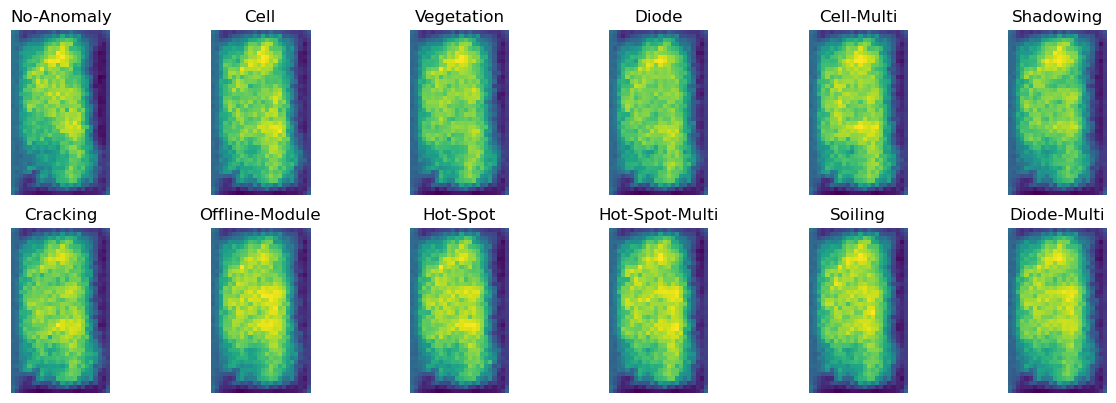

[Epoch 1/400] [D loss real: 0.5011252880096435, D loss fake: 0.49134926080703734] [G loss: 1.9667626309394837]
[Epoch 2/400] [D loss real: 0.4670521545410156, D loss fake: 0.46142721772193906] [G loss: 1.8070137643814086]
[Epoch 3/400] [D loss real: 0.4739198863506317, D loss fake: 0.4704952278733254] [G loss: 1.8435494661331178]
[Epoch 4/400] [D loss real: 0.43933884888887403, D loss fake: 0.4412028232216835] [G loss: 1.7497477555274963]
[Epoch 5/400] [D loss real: 0.4549602174758911, D loss fake: 0.4525690585374832] [G loss: 1.803130682706833]
[Epoch 6/400] [D loss real: 0.43820335835218427, D loss fake: 0.4428525295853615] [G loss: 1.7770226979255677]
[Epoch 7/400] [D loss real: 0.43596197754144667, D loss fake: 0.44412613302469256] [G loss: 1.7695498597621917]
[Epoch 8/400] [D loss real: 0.4289246612787247, D loss fake: 0.4299620059132576] [G loss: 1.6813103723526002]
[Epoch 9/400] [D loss real: 0.4313030597567558, D loss fake: 0.43402095466852186] [G loss: 1.7410975253582002]
[Epo

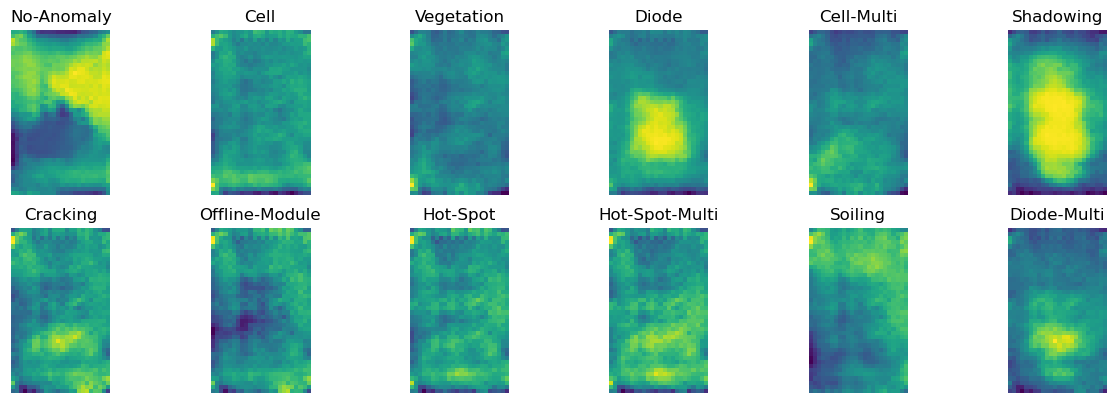

[Epoch 11/400] [D loss real: 0.5972833213210106, D loss fake: 0.580502819120884] [G loss: 1.386363086104393]
[Epoch 12/400] [D loss real: 0.6492281204462051, D loss fake: 0.6346658524870873] [G loss: 1.1374298471212387]
[Epoch 13/400] [D loss real: 0.6590292754769326, D loss fake: 0.6420201417803765] [G loss: 1.0845577001571656]
[Epoch 14/400] [D loss real: 0.6446296936273574, D loss fake: 0.6378999328613282] [G loss: 1.0327729547023774]
[Epoch 15/400] [D loss real: 0.6737746259570122, D loss fake: 0.6505374816060067] [G loss: 1.0691997450590134]
[Epoch 16/400] [D loss real: 0.6625875419378281, D loss fake: 0.6609313732385635] [G loss: 1.0219339036941528]
[Epoch 17/400] [D loss real: 0.6474493995308876, D loss fake: 0.6306974953413009] [G loss: 1.1748755741119385]
[Epoch 18/400] [D loss real: 0.6386648359894752, D loss fake: 0.6231968110799789] [G loss: 1.1747235077619553]
[Epoch 19/400] [D loss real: 0.6313179087638855, D loss fake: 0.6155104041099548] [G loss: 1.2600062221288681]
[Ep

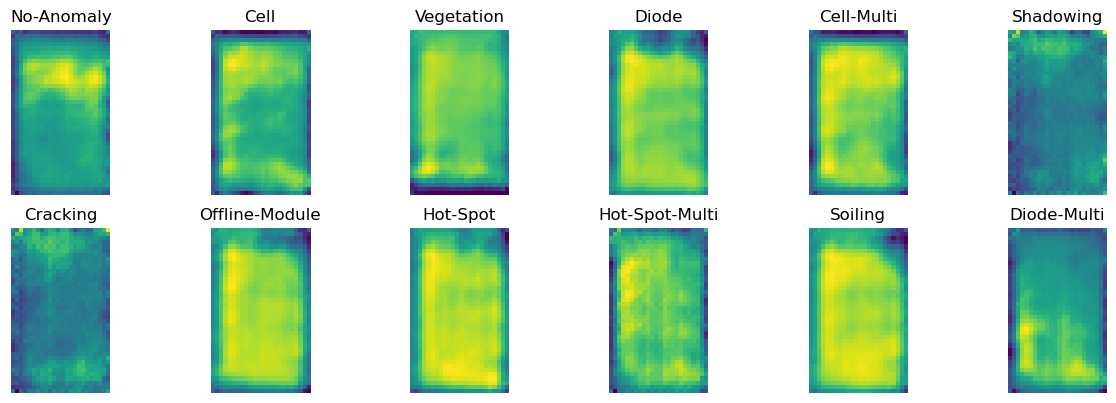

[Epoch 21/400] [D loss real: 0.590610836148262, D loss fake: 0.5777225515246391] [G loss: 1.3663743418455123]
[Epoch 22/400] [D loss real: 0.6452476423978806, D loss fake: 0.6403529593348503] [G loss: 1.153549197912216]
[Epoch 23/400] [D loss real: 0.6174478337168694, D loss fake: 0.6085732635855675] [G loss: 1.1705484068393708]
[Epoch 24/400] [D loss real: 0.6371586963534355, D loss fake: 0.6232869166135788] [G loss: 1.1883003830909729]
[Epoch 25/400] [D loss real: 0.6332716664671898, D loss fake: 0.6287618798017501] [G loss: 1.1208659344911576]
[Epoch 26/400] [D loss real: 0.6353327357769012, D loss fake: 0.6211766183376313] [G loss: 1.1287820219993592]
[Epoch 27/400] [D loss real: 0.6349518495798111, D loss fake: 0.6190756320953369] [G loss: 1.1858068537712096]
[Epoch 28/400] [D loss real: 0.6331729644536972, D loss fake: 0.6167384439706802] [G loss: 1.17338885307312]
[Epoch 29/400] [D loss real: 0.6054020446538925, D loss fake: 0.6001559934020042] [G loss: 1.2356363302469253]
[Epoc

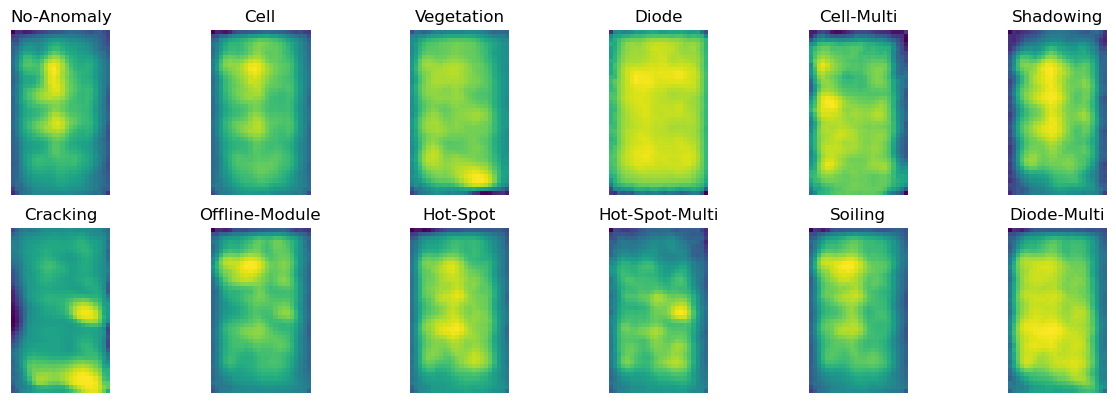

[Epoch 31/400] [D loss real: 0.5889430314302444, D loss fake: 0.5838154593110084] [G loss: 1.2766418439149856]
[Epoch 32/400] [D loss real: 0.6320588520169258, D loss fake: 0.6113180410861969] [G loss: 1.2297987294197084]
[Epoch 33/400] [D loss real: 0.617767240703106, D loss fake: 0.61034088909626] [G loss: 1.2666721016168594]
[Epoch 34/400] [D loss real: 0.6095497730374336, D loss fake: 0.5888554239273072] [G loss: 1.2790755075216294]
[Epoch 35/400] [D loss real: 0.6167661425471306, D loss fake: 0.6058107653260231] [G loss: 1.1928244209289551]
[Epoch 36/400] [D loss real: 0.6150305557250977, D loss fake: 0.6006034299731254] [G loss: 1.237370331287384]
[Epoch 37/400] [D loss real: 0.6227146452665329, D loss fake: 0.6090578126907349] [G loss: 1.2960638374090194]
[Epoch 38/400] [D loss real: 0.6232346749305725, D loss fake: 0.6022001206874847] [G loss: 1.2019185298681259]
[Epoch 39/400] [D loss real: 0.6419372513890267, D loss fake: 0.6262155625224114] [G loss: 1.130839861035347]
[Epoch

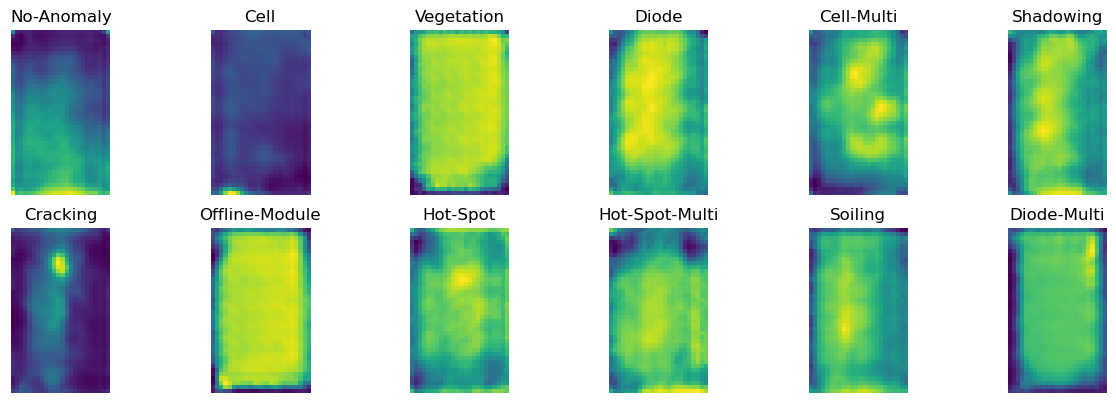

[Epoch 41/400] [D loss real: 0.6340457412600518, D loss fake: 0.6192632287740707] [G loss: 1.1977607655525206]
[Epoch 42/400] [D loss real: 0.6179649221897126, D loss fake: 0.605218356847763] [G loss: 1.236341844201088]
[Epoch 43/400] [D loss real: 0.6118737164139748, D loss fake: 0.5999477285146714] [G loss: 1.2393276530504227]
[Epoch 44/400] [D loss real: 0.6457180470228195, D loss fake: 0.626116573214531] [G loss: 1.1088551598787308]
[Epoch 45/400] [D loss real: 0.6003980964422226, D loss fake: 0.5918885442614555] [G loss: 1.2237225353717804]
[Epoch 46/400] [D loss real: 0.6272910171747208, D loss fake: 0.6115493777394295] [G loss: 1.189355906844139]
[Epoch 47/400] [D loss real: 0.6279536807537078, D loss fake: 0.6111808830499649] [G loss: 1.2313058382272721]
[Epoch 48/400] [D loss real: 0.6040933510661125, D loss fake: 0.5887774986028671] [G loss: 1.2245677351951598]
[Epoch 49/400] [D loss real: 0.6198593646287918, D loss fake: 0.6022469154000283] [G loss: 1.22161914229393]
[Epoch 

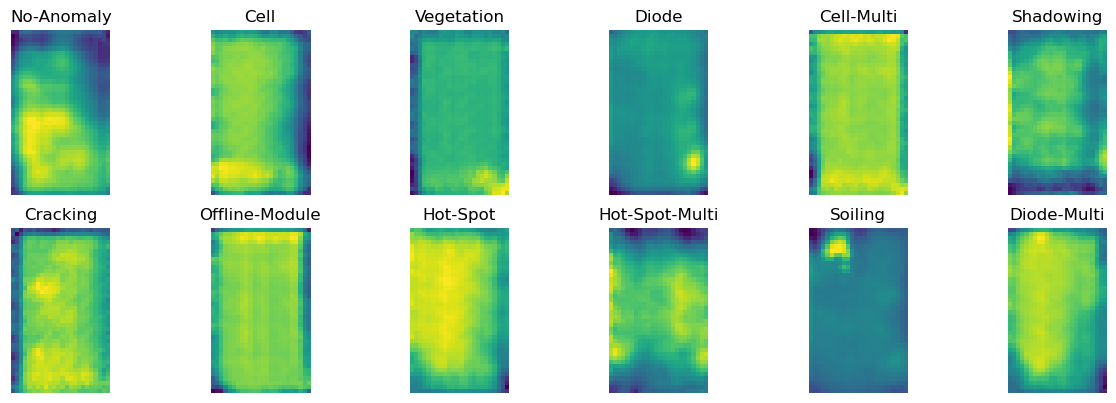

[Epoch 51/400] [D loss real: 0.5918676546216011, D loss fake: 0.585724824666977] [G loss: 1.2407658576965332]
[Epoch 52/400] [D loss real: 0.612190161049366, D loss fake: 0.5967311626672744] [G loss: 1.230215373635292]
[Epoch 53/400] [D loss real: 0.603671837747097, D loss fake: 0.5915163207054138] [G loss: 1.2208815360069274]
[Epoch 54/400] [D loss real: 0.6116097393631935, D loss fake: 0.5937042257189751] [G loss: 1.2793528151512146]
[Epoch 55/400] [D loss real: 0.5865702909231186, D loss fake: 0.576425496339798] [G loss: 1.2831703674793244]
[Epoch 56/400] [D loss real: 0.612498644888401, D loss fake: 0.5987383314967155] [G loss: 1.289952158331871]
[Epoch 57/400] [D loss real: 0.6067993998527527, D loss fake: 0.5980039885640145] [G loss: 1.2728787487745286]
[Epoch 58/400] [D loss real: 0.6188685685396195, D loss fake: 0.5883310675621033] [G loss: 1.3108162146806717]
[Epoch 59/400] [D loss real: 0.6422294437885284, D loss fake: 0.6242536669969558] [G loss: 1.118679123520851]
[Epoch 60

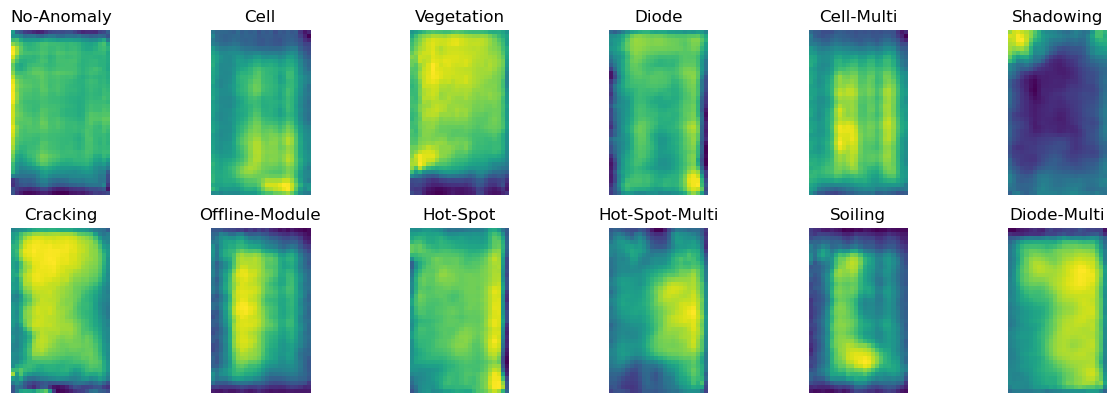

[Epoch 61/400] [D loss real: 0.633492779135704, D loss fake: 0.6189740535616874] [G loss: 1.180421819090843]
[Epoch 62/400] [D loss real: 0.6356687337160111, D loss fake: 0.6166707363724708] [G loss: 1.1828033757209777]
[Epoch 63/400] [D loss real: 0.6411388689279556, D loss fake: 0.6277917578816414] [G loss: 1.095580198764801]
[Epoch 64/400] [D loss real: 0.6339238548278808, D loss fake: 0.6167098984122277] [G loss: 1.1514946365356444]
[Epoch 65/400] [D loss real: 0.6273751437664032, D loss fake: 0.6149428382515907] [G loss: 1.2076131099462508]
[Epoch 66/400] [D loss real: 0.6020444911718369, D loss fake: 0.5885445317625999] [G loss: 1.2326241552829742]
[Epoch 67/400] [D loss real: 0.6011113983392715, D loss fake: 0.58989004611969] [G loss: 1.2293591296672821]
[Epoch 68/400] [D loss real: 0.5886910817027092, D loss fake: 0.587921089231968] [G loss: 1.2856440222263337]
[Epoch 69/400] [D loss real: 0.5899424648284912, D loss fake: 0.5769675037264824] [G loss: 1.2729343515634537]
[Epoch 

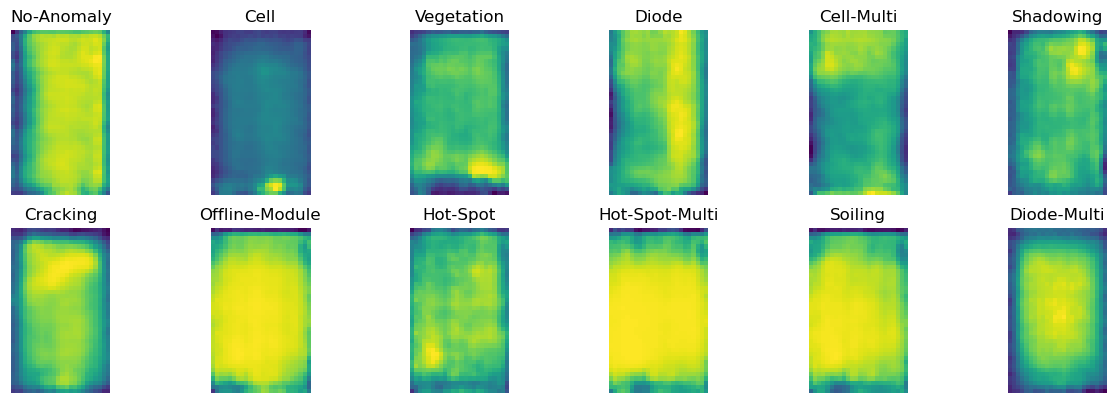

[Epoch 71/400] [D loss real: 0.5935424163937568, D loss fake: 0.5794136413931846] [G loss: 1.2439449191093446]
[Epoch 72/400] [D loss real: 0.5835149332880973, D loss fake: 0.5671285939216614] [G loss: 1.2904227751493453]
[Epoch 73/400] [D loss real: 0.5801331681013108, D loss fake: 0.5691454142332077] [G loss: 1.3156089305877685]
[Epoch 74/400] [D loss real: 0.6058215311169625, D loss fake: 0.5841014069318772] [G loss: 1.2834133780002595]
[Epoch 75/400] [D loss real: 0.5872493851184845, D loss fake: 0.5698980870842933] [G loss: 1.312439176440239]
[Epoch 76/400] [D loss real: 0.5979130783677101, D loss fake: 0.5840811467170716] [G loss: 1.2616852802038192]
[Epoch 77/400] [D loss real: 0.6024804931879043, D loss fake: 0.5850809380412102] [G loss: 1.2656377494335174]
[Epoch 78/400] [D loss real: 0.6181342259049416, D loss fake: 0.6075718265771866] [G loss: 1.136267627477646]
[Epoch 79/400] [D loss real: 0.6302007883787155, D loss fake: 0.614732731282711] [G loss: 1.1470994460582733]
[Epo

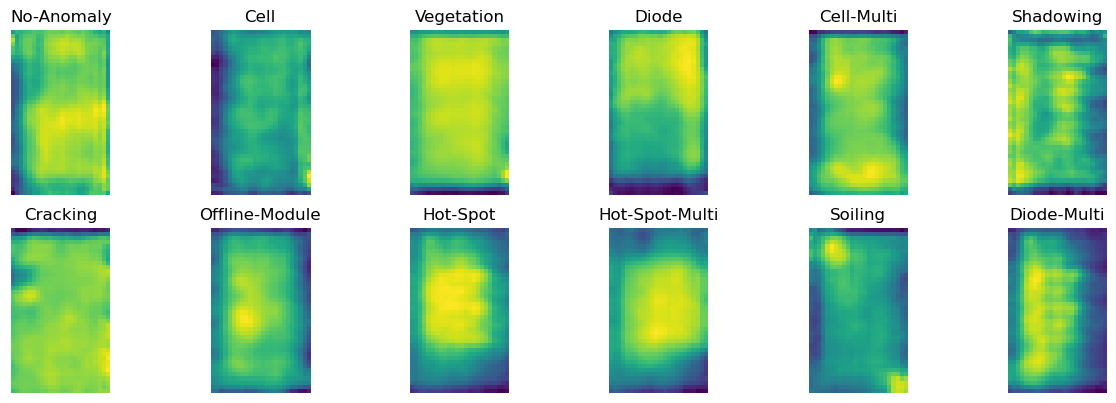

[Epoch 81/400] [D loss real: 0.6153014495968818, D loss fake: 0.6003451371192932] [G loss: 1.1979424607753755]
[Epoch 82/400] [D loss real: 0.5954751509428025, D loss fake: 0.5803944039344787] [G loss: 1.292088838815689]
[Epoch 83/400] [D loss real: 0.6043712362647057, D loss fake: 0.5900773540139198] [G loss: 1.2583621031045913]
[Epoch 84/400] [D loss real: 0.5857132896780968, D loss fake: 0.5717041930556297] [G loss: 1.4091175502538682]
[Epoch 85/400] [D loss real: 0.5776268869638443, D loss fake: 0.5660510894656181] [G loss: 1.3729296237230302]
[Epoch 86/400] [D loss real: 0.5920924013853073, D loss fake: 0.5768238514661789] [G loss: 1.3825516843795775]
[Epoch 87/400] [D loss real: 0.5889507684111596, D loss fake: 0.5736556893587113] [G loss: 1.3681813555955886]
[Epoch 88/400] [D loss real: 0.5954931882023812, D loss fake: 0.5806945124268532] [G loss: 1.3512146198749542]
[Epoch 89/400] [D loss real: 0.606929506957531, D loss fake: 0.5973831057548523] [G loss: 1.3003576749563217]
[Ep

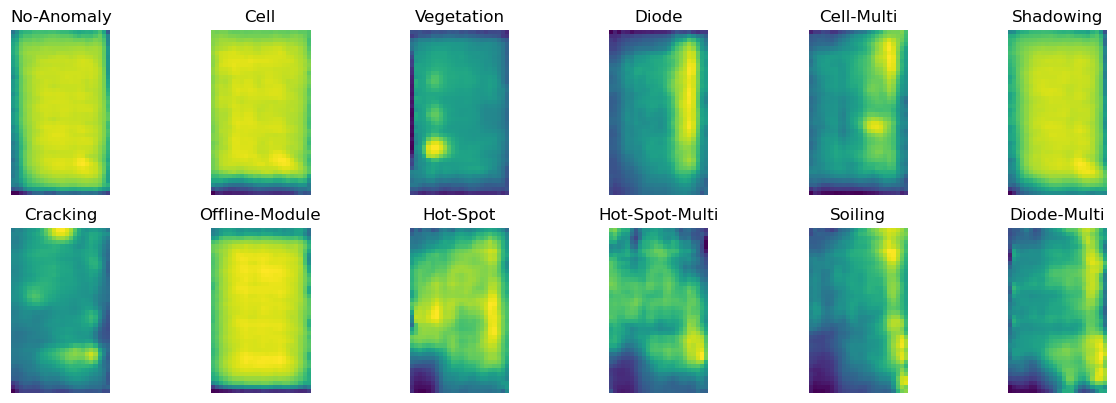

[Epoch 91/400] [D loss real: 0.572949148118496, D loss fake: 0.5590989592671395] [G loss: 1.4551737534999847]
[Epoch 92/400] [D loss real: 0.5837606447935104, D loss fake: 0.5703751558065414] [G loss: 1.387880733013153]
[Epoch 93/400] [D loss real: 0.563127835392952, D loss fake: 0.5541210666298866] [G loss: 1.407908091545105]
[Epoch 94/400] [D loss real: 0.5808914861083031, D loss fake: 0.5673573309183121] [G loss: 1.380132320523262]
[Epoch 95/400] [D loss real: 0.5657304137945175, D loss fake: 0.561287690103054] [G loss: 1.4852172541618347]
[Epoch 96/400] [D loss real: 0.5908618289232254, D loss fake: 0.5761363619565963] [G loss: 1.3377226054668427]
[Epoch 97/400] [D loss real: 0.5879613429307937, D loss fake: 0.5766626527905464] [G loss: 1.3288918900489808]
[Epoch 98/400] [D loss real: 0.5722716391086579, D loss fake: 0.5566155424714089] [G loss: 1.4706522101163864]
[Epoch 99/400] [D loss real: 0.5763837632536888, D loss fake: 0.5650325947999955] [G loss: 1.4708569526672364]
[Epoch 

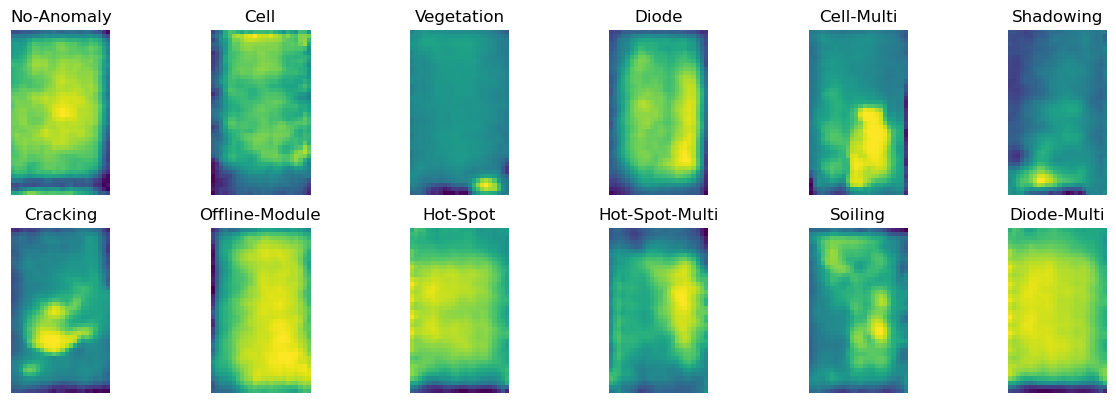

[Epoch 101/400] [D loss real: 0.5716711589694023, D loss fake: 0.557977586388588] [G loss: 1.4215003818273544]
[Epoch 102/400] [D loss real: 0.5476909601688384, D loss fake: 0.538086218237877] [G loss: 1.5599978923797608]
[Epoch 103/400] [D loss real: 0.5532101812958717, D loss fake: 0.5489768171310425] [G loss: 1.5121922671794892]
[Epoch 104/400] [D loss real: 0.5725592431426049, D loss fake: 0.5548809731006622] [G loss: 1.4666859686374665]
[Epoch 105/400] [D loss real: 0.5576369825005532, D loss fake: 0.5502482879161835] [G loss: 1.4892509579658508]
[Epoch 106/400] [D loss real: 0.5374109628796577, D loss fake: 0.5199518486857414] [G loss: 1.5907963180541993]
[Epoch 107/400] [D loss real: 0.5400725907087326, D loss fake: 0.536300144791603] [G loss: 1.585022184252739]
[Epoch 108/400] [D loss real: 0.5345485785603523, D loss fake: 0.5217662206292153] [G loss: 1.615569590330124]
[Epoch 109/400] [D loss real: 0.5467395895719528, D loss fake: 0.5301121208071709] [G loss: 1.547629010677337

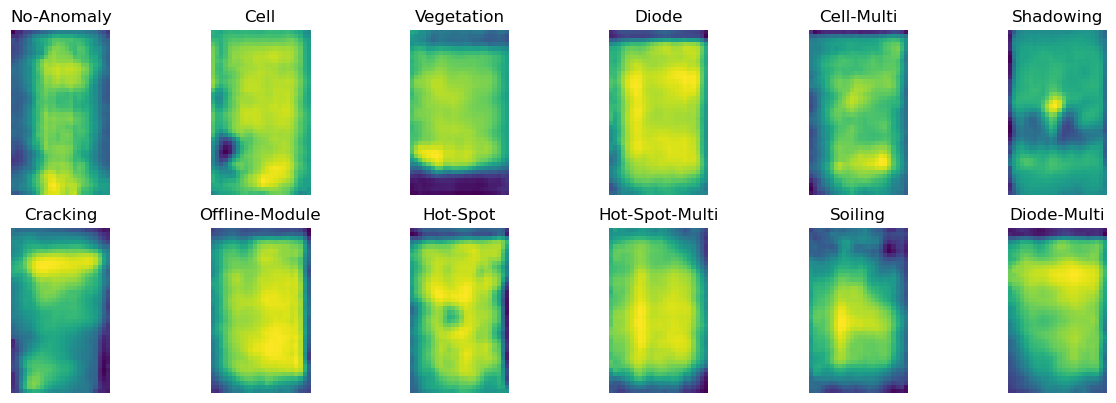

[Epoch 111/400] [D loss real: 0.5442933508753777, D loss fake: 0.5275790521502495] [G loss: 1.5991906321048737]
[Epoch 112/400] [D loss real: 0.5367567476630211, D loss fake: 0.5233071821928025] [G loss: 1.5943534111976623]
[Epoch 113/400] [D loss real: 0.556984543800354, D loss fake: 0.5459575974941253] [G loss: 1.5548099541664124]
[Epoch 114/400] [D loss real: 0.5212147709727287, D loss fake: 0.5148174643516541] [G loss: 1.652506837248802]
[Epoch 115/400] [D loss real: 0.5454282999038697, D loss fake: 0.5392443028092384] [G loss: 1.6676615762710572]
[Epoch 116/400] [D loss real: 0.5344834867119789, D loss fake: 0.5249978333711625] [G loss: 1.6288189905881882]
[Epoch 117/400] [D loss real: 0.5229441222548484, D loss fake: 0.5149764424562454] [G loss: 1.6718679052591323]
[Epoch 118/400] [D loss real: 0.5320114639401435, D loss fake: 0.511460916697979] [G loss: 1.6031222665309905]
[Epoch 119/400] [D loss real: 0.5426686295866966, D loss fake: 0.5332525044679641] [G loss: 1.6252091562747

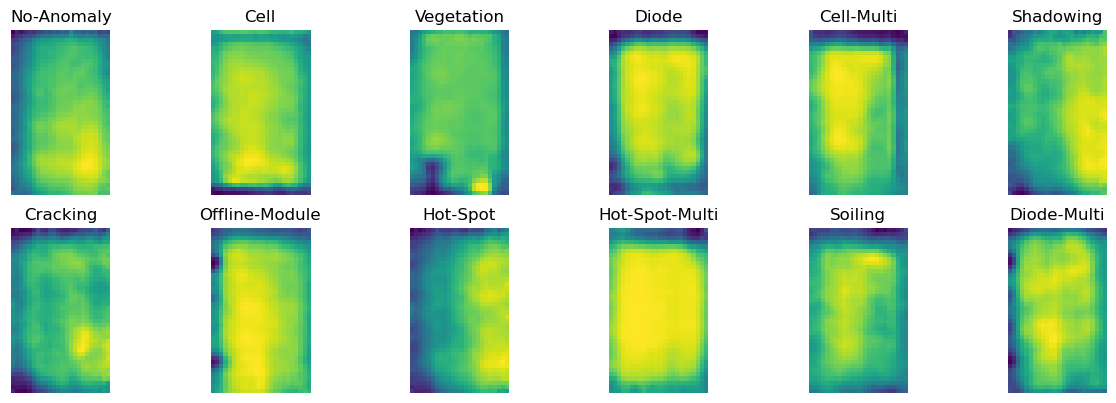

[Epoch 121/400] [D loss real: 0.5193239653110504, D loss fake: 0.5042186844348907] [G loss: 1.6338966703414917]
[Epoch 122/400] [D loss real: 0.5262618780136108, D loss fake: 0.5150668895244599] [G loss: 1.654636013507843]
[Epoch 123/400] [D loss real: 0.5373877659440041, D loss fake: 0.526962305009365] [G loss: 1.6224580550193786]
[Epoch 124/400] [D loss real: 0.5394810727238655, D loss fake: 0.5260038074851036] [G loss: 1.6359997475147248]
[Epoch 125/400] [D loss real: 0.5069976425170899, D loss fake: 0.49921013951301574] [G loss: 1.6984381592273712]
[Epoch 126/400] [D loss real: 0.4914109402894974, D loss fake: 0.4916807210445404] [G loss: 1.8012381398677826]
[Epoch 127/400] [D loss real: 0.5146509951353073, D loss fake: 0.5080861186981201] [G loss: 1.7258289510011673]
[Epoch 128/400] [D loss real: 0.49902827978134157, D loss fake: 0.4940041592717171] [G loss: 1.694125279188156]
[Epoch 129/400] [D loss real: 0.5085448992252349, D loss fake: 0.5054455786943436] [G loss: 1.78457539260

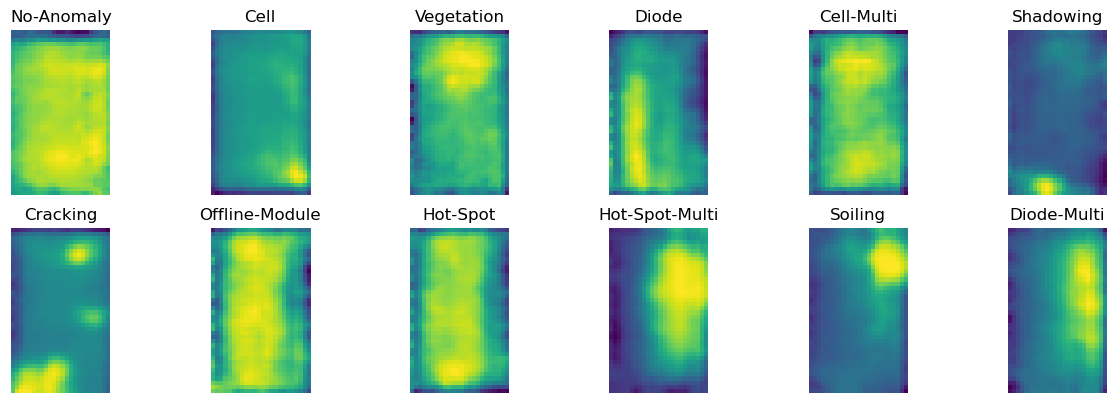

[Epoch 131/400] [D loss real: 0.5013602483272552, D loss fake: 0.4979507073760033] [G loss: 1.7434304189682006]
[Epoch 132/400] [D loss real: 0.49318804740905764, D loss fake: 0.4884124168753624] [G loss: 1.749318505525589]
[Epoch 133/400] [D loss real: 0.49728225260972975, D loss fake: 0.4886520454287529] [G loss: 1.6922277545928954]
[Epoch 134/400] [D loss real: 0.4955366438627243, D loss fake: 0.48254213750362396] [G loss: 1.7302257001399994]
[Epoch 135/400] [D loss real: 0.4906034862995148, D loss fake: 0.4967037633061409] [G loss: 1.7562823212146759]
[Epoch 136/400] [D loss real: 0.5055184707045555, D loss fake: 0.5025812566280365] [G loss: 1.7257411968708039]
[Epoch 137/400] [D loss real: 0.4966354876756668, D loss fake: 0.4955306154489517] [G loss: 1.7249662029743194]
[Epoch 138/400] [D loss real: 0.49904132962226866, D loss fake: 0.4903484445810318] [G loss: 1.7149836313724518]
[Epoch 139/400] [D loss real: 0.49561488956212996, D loss fake: 0.4946366727352142] [G loss: 1.731069

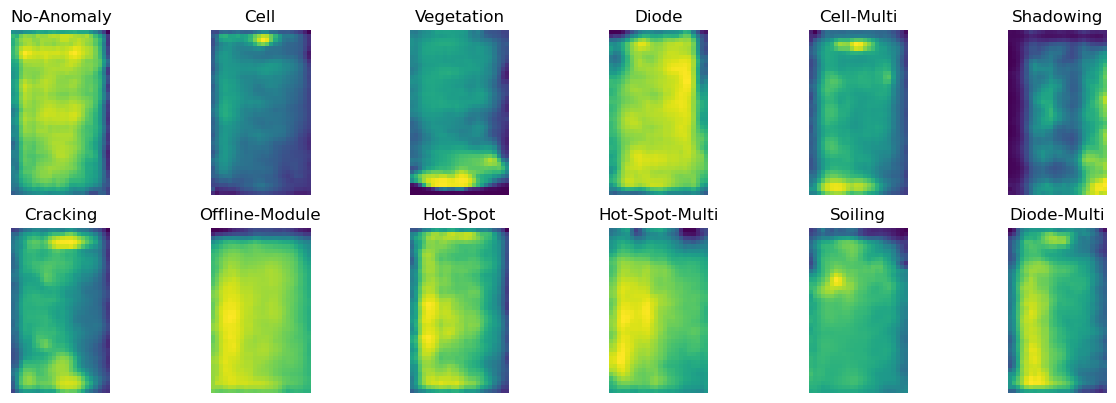

[Epoch 141/400] [D loss real: 0.4870643109083176, D loss fake: 0.48736130326986316] [G loss: 1.749117636680603]
[Epoch 142/400] [D loss real: 0.4941717314720154, D loss fake: 0.49248400300741196] [G loss: 1.7250818085670472]
[Epoch 143/400] [D loss real: 0.49248596966266633, D loss fake: 0.488105788230896] [G loss: 1.6925138956308365]
[Epoch 144/400] [D loss real: 0.4966890078783035, D loss fake: 0.4824545410275459] [G loss: 1.7741470658779144]
[Epoch 145/400] [D loss real: 0.4933302441239357, D loss fake: 0.49100560039281843] [G loss: 1.734756624698639]
[Epoch 146/400] [D loss real: 0.49108580470085145, D loss fake: 0.4902343678474426] [G loss: 1.7348165076971054]
[Epoch 147/400] [D loss real: 0.5084812703728676, D loss fake: 0.5025906339287758] [G loss: 1.718949350118637]
[Epoch 148/400] [D loss real: 0.4985111829638481, D loss fake: 0.4951776987314224] [G loss: 1.716175261735916]
[Epoch 149/400] [D loss real: 0.5006444799900055, D loss fake: 0.48567952364683153] [G loss: 1.742109299

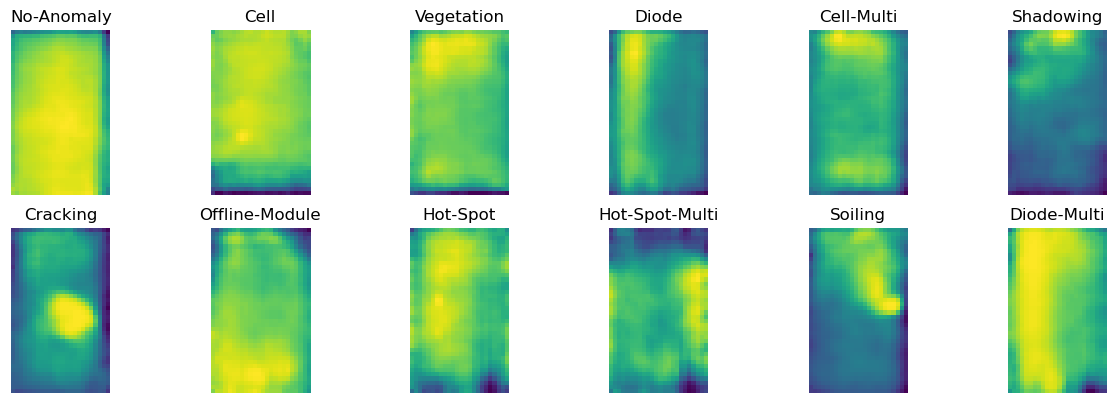

[Epoch 151/400] [D loss real: 0.48533559054136277, D loss fake: 0.49127818644046783] [G loss: 1.8666851210594178]
[Epoch 152/400] [D loss real: 0.48092121541500094, D loss fake: 0.47238547295331956] [G loss: 1.7628142070770263]
[Epoch 153/400] [D loss real: 0.49467877924442294, D loss fake: 0.4910154086351395] [G loss: 1.7614507108926774]
[Epoch 154/400] [D loss real: 0.4822584664821625, D loss fake: 0.4821155974268913] [G loss: 1.7668303084373473]
[Epoch 155/400] [D loss real: 0.478028801381588, D loss fake: 0.4775893327593803] [G loss: 1.791989622116089]
[Epoch 156/400] [D loss real: 0.49023033678531647, D loss fake: 0.48922257363796234] [G loss: 1.8101011556386948]
[Epoch 157/400] [D loss real: 0.4956071028113365, D loss fake: 0.486539765894413] [G loss: 1.6865856349468231]
[Epoch 158/400] [D loss real: 0.48013064175844195, D loss fake: 0.48365684419870375] [G loss: 1.758606685400009]
[Epoch 159/400] [D loss real: 0.49614823043346407, D loss fake: 0.490558260679245] [G loss: 1.69130

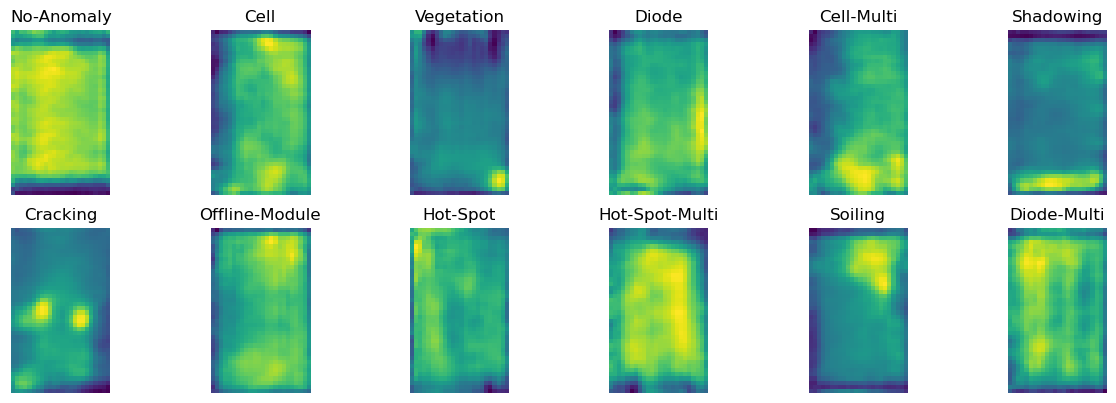

[Epoch 161/400] [D loss real: 0.5020843133330345, D loss fake: 0.4923311200737953] [G loss: 1.6847123569250106]
[Epoch 162/400] [D loss real: 0.5036569917201996, D loss fake: 0.49151022285223006] [G loss: 1.7259144061803817]
[Epoch 163/400] [D loss real: 0.5047625783085823, D loss fake: 0.4995609655976295] [G loss: 1.7263166403770447]
[Epoch 164/400] [D loss real: 0.5005050754547119, D loss fake: 0.49946227461099624] [G loss: 1.7173901718854905]
[Epoch 165/400] [D loss real: 0.517190625667572, D loss fake: 0.5116694211959839] [G loss: 1.6600749123096465]
[Epoch 166/400] [D loss real: 0.5195788049697876, D loss fake: 0.5041686484217643] [G loss: 1.6640988796949387]
[Epoch 167/400] [D loss real: 0.5171296024322509, D loss fake: 0.5161295717954636] [G loss: 1.6949615055322647]
[Epoch 168/400] [D loss real: 0.5301691579818726, D loss fake: 0.5180272382497787] [G loss: 1.596078914999962]
[Epoch 169/400] [D loss real: 0.513064024746418, D loss fake: 0.49886606991291044] [G loss: 1.6464167189

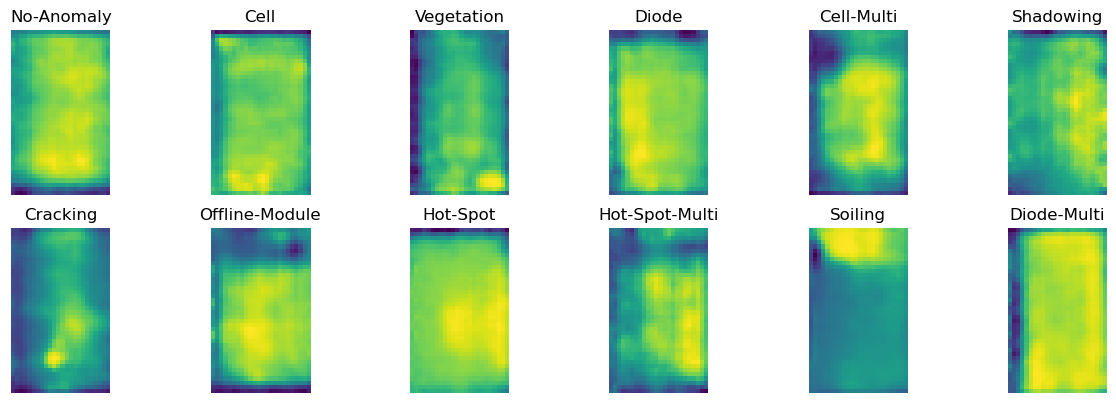

[Epoch 171/400] [D loss real: 0.513319762647152, D loss fake: 0.5069762906432151] [G loss: 1.6740844386816025]
[Epoch 172/400] [D loss real: 0.5216275289654732, D loss fake: 0.5127142506837845] [G loss: 1.6920760190486908]
[Epoch 173/400] [D loss real: 0.5244277217984199, D loss fake: 0.5186918979883194] [G loss: 1.6772799098491669]
[Epoch 174/400] [D loss real: 0.5241583076119423, D loss fake: 0.5079709944128991] [G loss: 1.655449892282486]
[Epoch 175/400] [D loss real: 0.5255283409357071, D loss fake: 0.5181873217225075] [G loss: 1.6374586999416352]
[Epoch 176/400] [D loss real: 0.520888936817646, D loss fake: 0.508167732656002] [G loss: 1.6539532822370528]
[Epoch 177/400] [D loss real: 0.5245411637425422, D loss fake: 0.5127094259858131] [G loss: 1.597884396314621]
[Epoch 178/400] [D loss real: 0.515289990901947, D loss fake: 0.5076408278942108] [G loss: 1.6670661169290542]
[Epoch 179/400] [D loss real: 0.5109023958444595, D loss fake: 0.49813545048236846] [G loss: 1.676485533714294

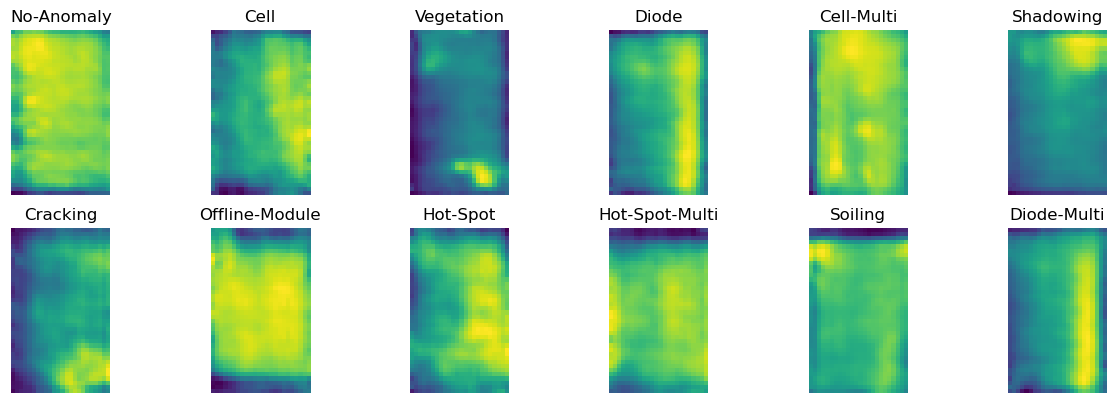

[Epoch 181/400] [D loss real: 0.5100920152664185, D loss fake: 0.5007483097910881] [G loss: 1.730798635482788]
[Epoch 182/400] [D loss real: 0.4982744589447975, D loss fake: 0.49820797473192213] [G loss: 1.7295011055469514]
[Epoch 183/400] [D loss real: 0.5159892767667771, D loss fake: 0.5115303125977516] [G loss: 1.7065424722433091]
[Epoch 184/400] [D loss real: 0.5072061082720757, D loss fake: 0.5002359005808831] [G loss: 1.6783671748638154]
[Epoch 185/400] [D loss real: 0.5066307434439659, D loss fake: 0.49530232936143875] [G loss: 1.6672173446416856]
[Epoch 186/400] [D loss real: 0.4925959891080856, D loss fake: 0.4839452111721039] [G loss: 1.7003407311439513]
[Epoch 187/400] [D loss real: 0.4885178774595261, D loss fake: 0.48395751029253004] [G loss: 1.7294454276561737]
[Epoch 188/400] [D loss real: 0.48884364515542983, D loss fake: 0.4860083028674126] [G loss: 1.7398706859350204]
[Epoch 189/400] [D loss real: 0.5004809561371804, D loss fake: 0.4918553423881531] [G loss: 1.7894582

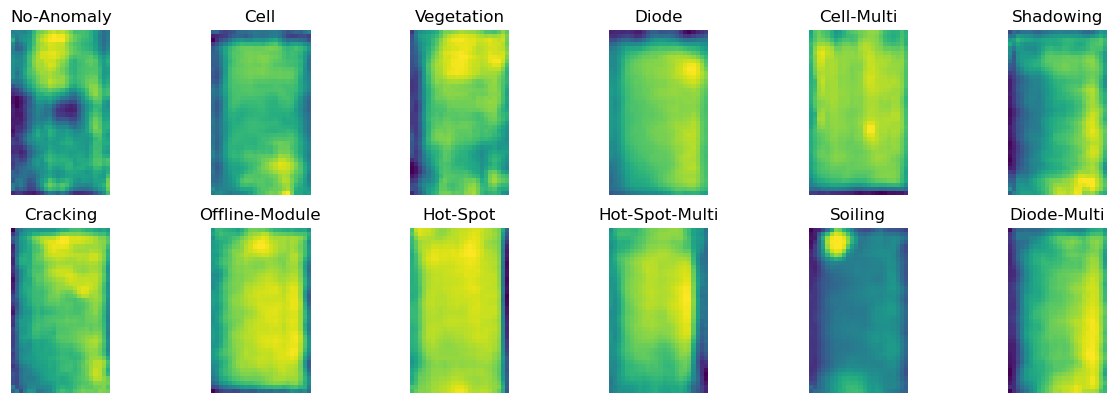

[Epoch 191/400] [D loss real: 0.49380567848682405, D loss fake: 0.48856122940778735] [G loss: 1.743187427520752]
[Epoch 192/400] [D loss real: 0.4922202956676483, D loss fake: 0.48656761735677717] [G loss: 1.7830254125595093]
[Epoch 193/400] [D loss real: 0.5028582599759102, D loss fake: 0.49076282024383544] [G loss: 1.6809721648693086]
[Epoch 194/400] [D loss real: 0.5074507781863212, D loss fake: 0.4957905668020248] [G loss: 1.6850529253482818]
[Epoch 195/400] [D loss real: 0.49948706597089765, D loss fake: 0.4969500207901001] [G loss: 1.7467176342010498]
[Epoch 196/400] [D loss real: 0.494538451731205, D loss fake: 0.4881544598937035] [G loss: 1.802605965733528]
[Epoch 197/400] [D loss real: 0.49913653880357745, D loss fake: 0.4854042214155197] [G loss: 1.696618983745575]
[Epoch 198/400] [D loss real: 0.501810584962368, D loss fake: 0.4902295857667923] [G loss: 1.7221992599964142]
[Epoch 199/400] [D loss real: 0.5026829501986504, D loss fake: 0.4992373737692833] [G loss: 1.787436250

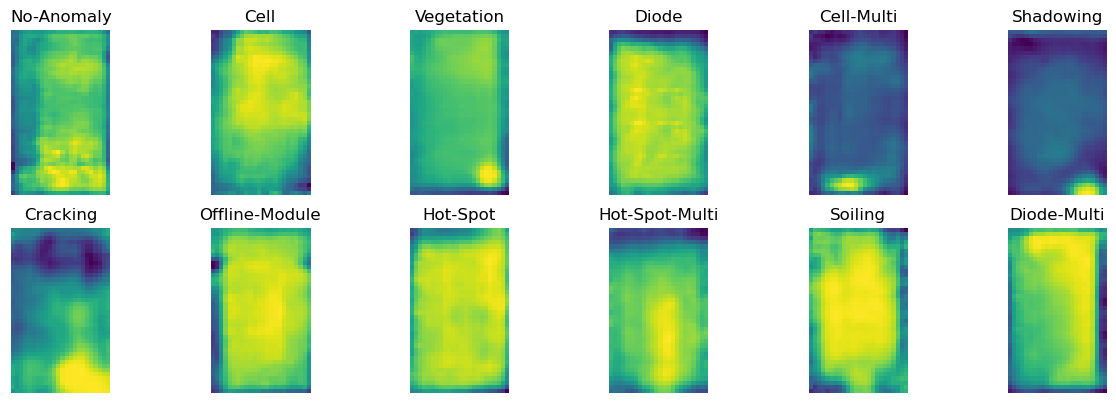

[Epoch 201/400] [D loss real: 0.5055421227216721, D loss fake: 0.49557854384183886] [G loss: 1.7156297820806503]
[Epoch 202/400] [D loss real: 0.5031565880775452, D loss fake: 0.49749510586261747] [G loss: 1.793679050207138]
[Epoch 203/400] [D loss real: 0.5008227255940437, D loss fake: 0.4861645659804344] [G loss: 1.7377823305130005]
[Epoch 204/400] [D loss real: 0.49189276337623594, D loss fake: 0.48640966475009917] [G loss: 1.7564451956748963]
[Epoch 205/400] [D loss real: 0.49085875749588015, D loss fake: 0.4814810720086098] [G loss: 1.7722883158922196]
[Epoch 206/400] [D loss real: 0.48466713637113573, D loss fake: 0.4834276247024536] [G loss: 1.7441853785514831]
[Epoch 207/400] [D loss real: 0.49052165657281876, D loss fake: 0.4841263136267662] [G loss: 1.74498492538929]
[Epoch 208/400] [D loss real: 0.4848089689016342, D loss fake: 0.4789236626029015] [G loss: 1.7365190076828003]
[Epoch 209/400] [D loss real: 0.4944185948371887, D loss fake: 0.4939344221353531] [G loss: 1.804093

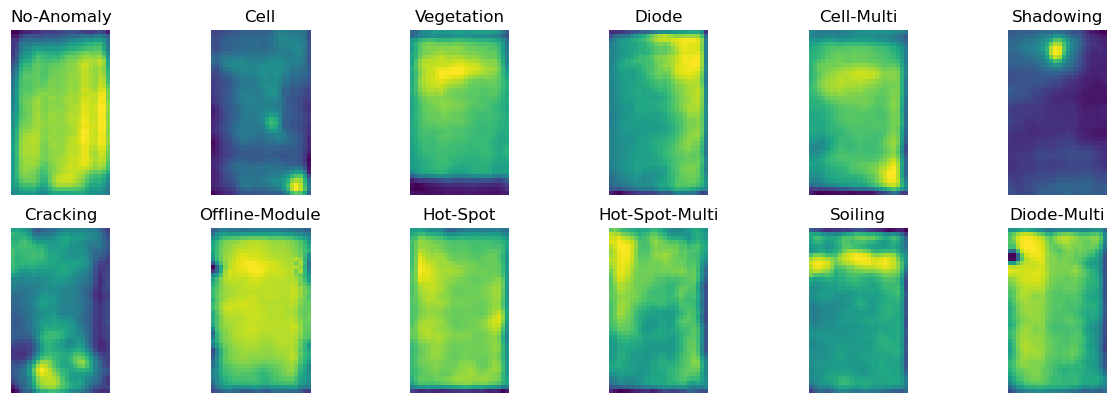

[Epoch 211/400] [D loss real: 0.48027879387140276, D loss fake: 0.4700529536604881] [G loss: 1.7699158370494843]
[Epoch 212/400] [D loss real: 0.4927139648795128, D loss fake: 0.4888493099808693] [G loss: 1.786037687063217]
[Epoch 213/400] [D loss real: 0.4942686802148819, D loss fake: 0.48095123678445817] [G loss: 1.731837505698204]
[Epoch 214/400] [D loss real: 0.4957836958765984, D loss fake: 0.486294282078743] [G loss: 1.7486716216802598]
[Epoch 215/400] [D loss real: 0.48685846745967865, D loss fake: 0.48059185802936555] [G loss: 1.7677085041999816]
[Epoch 216/400] [D loss real: 0.49223462492227554, D loss fake: 0.4928732305765152] [G loss: 1.766870841383934]
[Epoch 217/400] [D loss real: 0.49077380150556565, D loss fake: 0.48691036909818647] [G loss: 1.802517294883728]
[Epoch 218/400] [D loss real: 0.4910742062330246, D loss fake: 0.4891009670495987] [G loss: 1.7757897913455962]
[Epoch 219/400] [D loss real: 0.4897534915804863, D loss fake: 0.4856051704287529] [G loss: 1.73106971

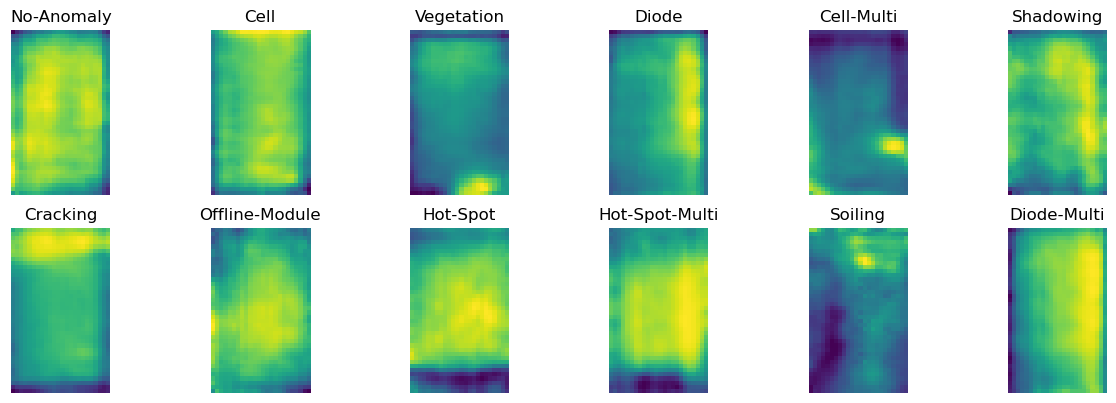

[Epoch 221/400] [D loss real: 0.49423898607492445, D loss fake: 0.4819136306643486] [G loss: 1.7289816927909851]
[Epoch 222/400] [D loss real: 0.49303372293710707, D loss fake: 0.48478627026081084] [G loss: 1.7642748135328292]
[Epoch 223/400] [D loss real: 0.4989466017484665, D loss fake: 0.490302212536335] [G loss: 1.7439371079206467]
[Epoch 224/400] [D loss real: 0.4816220799088478, D loss fake: 0.4720720145106316] [G loss: 1.7150552582740783]
[Epoch 225/400] [D loss real: 0.49249483048915865, D loss fake: 0.4847779995203018] [G loss: 1.7291266167163848]
[Epoch 226/400] [D loss real: 0.4955963757634163, D loss fake: 0.48584537029266356] [G loss: 1.743570969104767]
[Epoch 227/400] [D loss real: 0.4928176686167717, D loss fake: 0.4876781675219536] [G loss: 1.7662897831201554]
[Epoch 228/400] [D loss real: 0.4997878175973892, D loss fake: 0.4897243186831474] [G loss: 1.7447449970245361]
[Epoch 229/400] [D loss real: 0.48791722774505614, D loss fake: 0.4874452990293503] [G loss: 1.765434

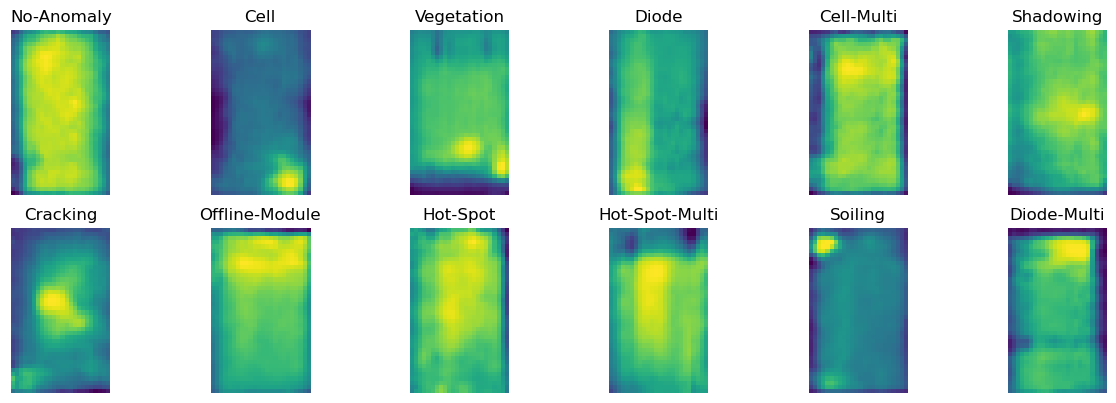

[Epoch 231/400] [D loss real: 0.5009370386600495, D loss fake: 0.49139488518238067] [G loss: 1.7076105451583863]
[Epoch 232/400] [D loss real: 0.49933521300554273, D loss fake: 0.48644721806049346] [G loss: 1.75173554956913]
[Epoch 233/400] [D loss real: 0.48529774099588396, D loss fake: 0.48030465841293335] [G loss: 1.7699881500005723]
[Epoch 234/400] [D loss real: 0.49832335382699966, D loss fake: 0.4910006010532379] [G loss: 1.771311069726944]
[Epoch 235/400] [D loss real: 0.49834012299776076, D loss fake: 0.4847328343987465] [G loss: 1.7459039914608]
[Epoch 236/400] [D loss real: 0.5028352069854737, D loss fake: 0.4987586137652397] [G loss: 1.7576385152339935]
[Epoch 237/400] [D loss real: 0.49559627860784533, D loss fake: 0.4876757290959358] [G loss: 1.7454243063926698]
[Epoch 238/400] [D loss real: 0.5005772739648819, D loss fake: 0.49078946381807326] [G loss: 1.8241106629371644]
[Epoch 239/400] [D loss real: 0.49844176560640335, D loss fake: 0.5036159268021584] [G loss: 1.749389

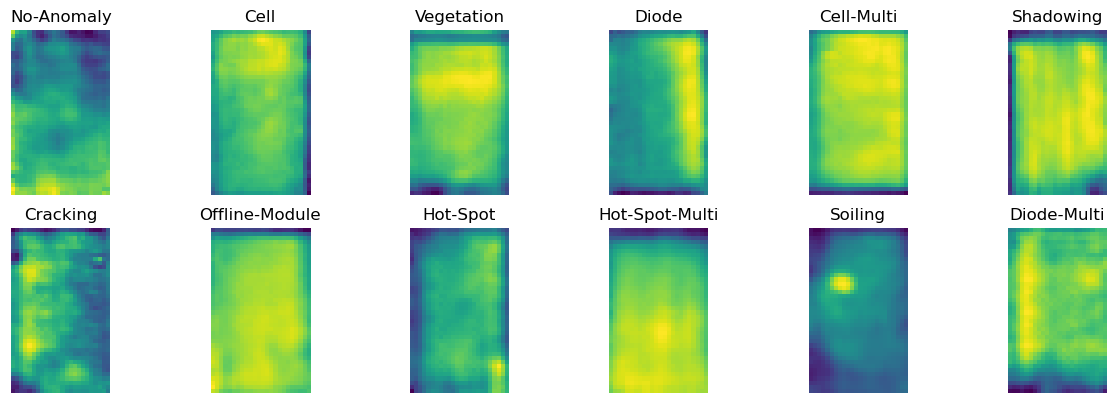

[Epoch 241/400] [D loss real: 0.4880824562907219, D loss fake: 0.47999458968639375] [G loss: 1.7172718906402589]
[Epoch 242/400] [D loss real: 0.49011659264564517, D loss fake: 0.48515523493289947] [G loss: 1.7537832152843476]
[Epoch 243/400] [D loss real: 0.48540432304143905, D loss fake: 0.4784377607703209] [G loss: 1.7237947034835814]
[Epoch 244/400] [D loss real: 0.5095253136754035, D loss fake: 0.49631687432527544] [G loss: 1.728085817694664]
[Epoch 245/400] [D loss real: 0.4968446850776672, D loss fake: 0.48766055315732953] [G loss: 1.7669057381153106]
[Epoch 246/400] [D loss real: 0.49108170688152314, D loss fake: 0.4847924980521202] [G loss: 1.7916679358482361]
[Epoch 247/400] [D loss real: 0.48589943021535875, D loss fake: 0.48281667470932005] [G loss: 1.7893804836273193]
[Epoch 248/400] [D loss real: 0.4838409027457237, D loss fake: 0.48839605033397676] [G loss: 1.7960708075761795]
[Epoch 249/400] [D loss real: 0.49143799394369125, D loss fake: 0.47662307262420656] [G loss: 1

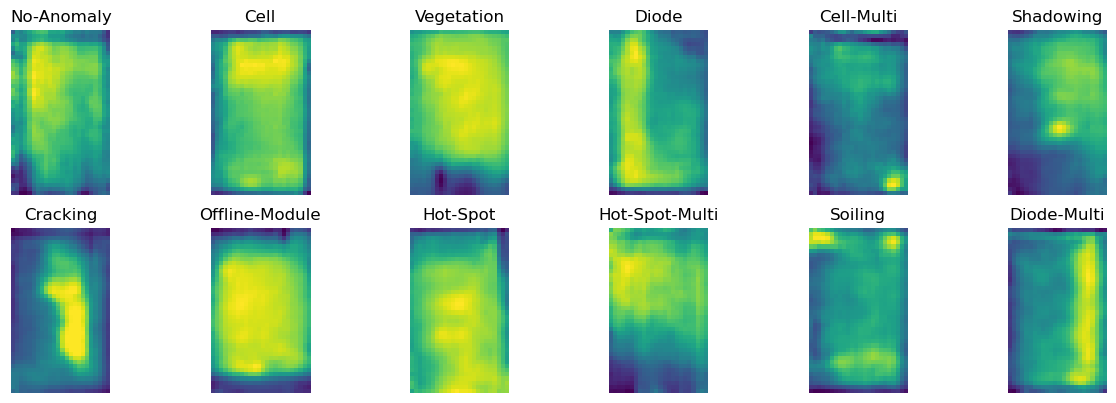

[Epoch 251/400] [D loss real: 0.4945484411716461, D loss fake: 0.4847196266055107] [G loss: 1.7472460329532624]
[Epoch 252/400] [D loss real: 0.4955465868115425, D loss fake: 0.48716966032981873] [G loss: 1.753442553281784]
[Epoch 253/400] [D loss real: 0.49346069544553756, D loss fake: 0.4928186938166618] [G loss: 1.7624779880046844]
[Epoch 254/400] [D loss real: 0.49013452559709547, D loss fake: 0.4857862314581871] [G loss: 1.7940572464466096]
[Epoch 255/400] [D loss real: 0.48001698046922686, D loss fake: 0.47745895117521286] [G loss: 1.7868866056203843]
[Epoch 256/400] [D loss real: 0.4878565427660942, D loss fake: 0.47792156517505646] [G loss: 1.8162051647901536]
[Epoch 257/400] [D loss real: 0.4864572209119797, D loss fake: 0.47720304906368255] [G loss: 1.7607609367370605]
[Epoch 258/400] [D loss real: 0.4848565289378166, D loss fake: 0.48239974200725555] [G loss: 1.7715879678726196]
[Epoch 259/400] [D loss real: 0.475737861096859, D loss fake: 0.4718012025952339] [G loss: 1.7688

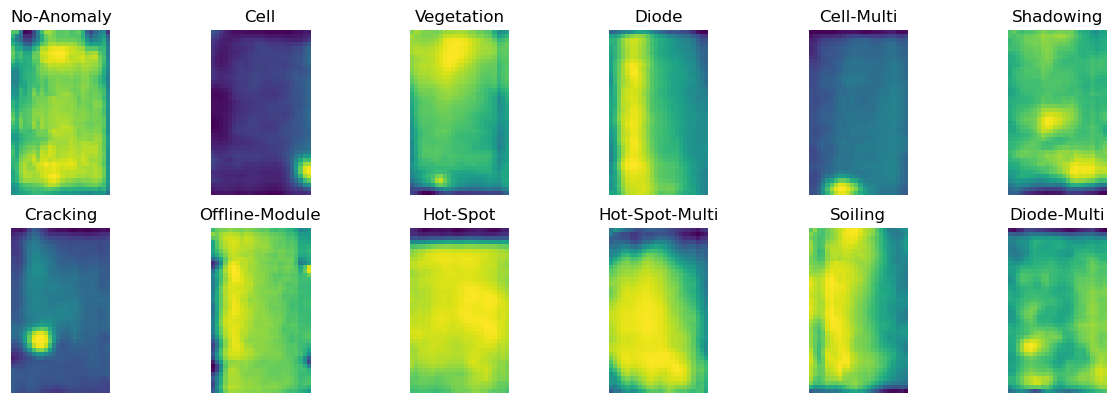

[Epoch 261/400] [D loss real: 0.4905201107263565, D loss fake: 0.4792743667960167] [G loss: 1.7755401396751405]
[Epoch 262/400] [D loss real: 0.48257614612579347, D loss fake: 0.479137005507946] [G loss: 1.7531505036354065]
[Epoch 263/400] [D loss real: 0.4871838563680649, D loss fake: 0.48282628029584884] [G loss: 1.828833127617836]
[Epoch 264/400] [D loss real: 0.48745959997177124, D loss fake: 0.4801283338665962] [G loss: 1.7615676403045655]
[Epoch 265/400] [D loss real: 0.5047436088323594, D loss fake: 0.49347788631916045] [G loss: 1.7506506323814393]
[Epoch 266/400] [D loss real: 0.4891508129239082, D loss fake: 0.48383776992559435] [G loss: 1.7517019593715668]
[Epoch 267/400] [D loss real: 0.49048891574144365, D loss fake: 0.48909624576568606] [G loss: 1.7126163172721862]
[Epoch 268/400] [D loss real: 0.482991184592247, D loss fake: 0.4748227319121361] [G loss: 1.738843013048172]
[Epoch 269/400] [D loss real: 0.4990574336051941, D loss fake: 0.4842718267440796] [G loss: 1.7225164

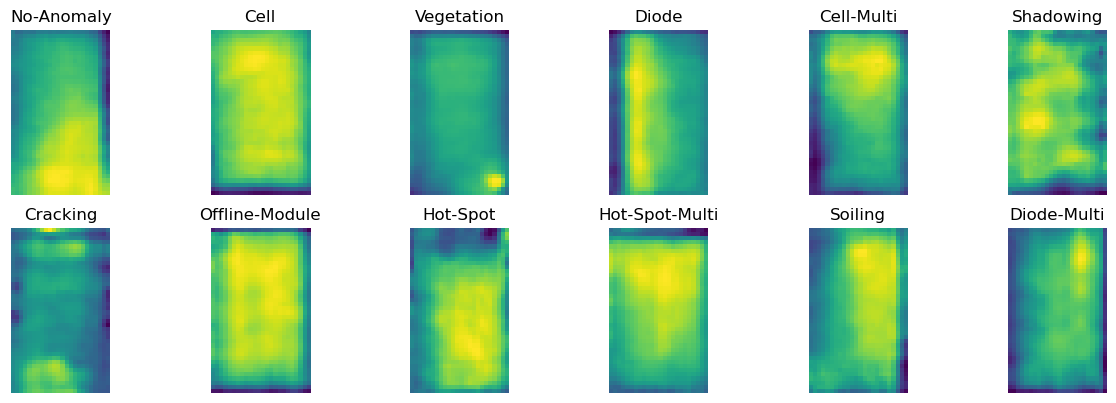

[Epoch 271/400] [D loss real: 0.489889377951622, D loss fake: 0.4825709646940231] [G loss: 1.7492966681718827]
[Epoch 272/400] [D loss real: 0.4896967747807503, D loss fake: 0.4822247952222824] [G loss: 1.7380571925640107]
[Epoch 273/400] [D loss real: 0.48232457906007764, D loss fake: 0.47671951085329056] [G loss: 1.7394645667076112]
[Epoch 274/400] [D loss real: 0.4906047335267067, D loss fake: 0.4852847787737846] [G loss: 1.7599918174743652]
[Epoch 275/400] [D loss real: 0.4829091829061508, D loss fake: 0.48424816131591797] [G loss: 1.8019792747497558]
[Epoch 276/400] [D loss real: 0.48147008806467056, D loss fake: 0.4723953801393509] [G loss: 1.7416223418712615]
[Epoch 277/400] [D loss real: 0.49352999597787856, D loss fake: 0.4955485638976097] [G loss: 1.8108184611797333]
[Epoch 278/400] [D loss real: 0.47553734213113785, D loss fake: 0.47512106895446776] [G loss: 1.7644140362739562]
[Epoch 279/400] [D loss real: 0.49676463156938555, D loss fake: 0.49654103338718414] [G loss: 1.81

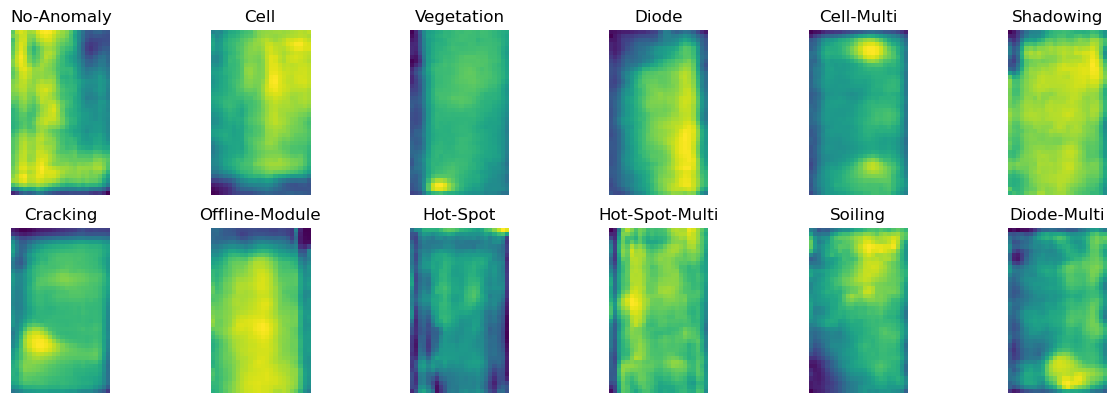

[Epoch 281/400] [D loss real: 0.48164729356765745, D loss fake: 0.4700284644961357] [G loss: 1.7552368021011353]
[Epoch 282/400] [D loss real: 0.48291757196187973, D loss fake: 0.47872176378965375] [G loss: 1.78751267015934]
[Epoch 283/400] [D loss real: 0.4829577398300171, D loss fake: 0.47977772235870364] [G loss: 1.7386769753694535]
[Epoch 284/400] [D loss real: 0.49049103528261184, D loss fake: 0.486955124437809] [G loss: 1.728970313668251]
[Epoch 285/400] [D loss real: 0.4849964854121208, D loss fake: 0.4843190935254097] [G loss: 1.8300882172584534]
[Epoch 286/400] [D loss real: 0.4949601405858994, D loss fake: 0.4862072592973709] [G loss: 1.7790083771944045]
[Epoch 287/400] [D loss real: 0.48228624790906904, D loss fake: 0.479044449031353] [G loss: 1.7885480272769927]
[Epoch 288/400] [D loss real: 0.4828279054164886, D loss fake: 0.4829782420396805] [G loss: 1.7596917355060577]
[Epoch 289/400] [D loss real: 0.4806530475616455, D loss fake: 0.4796110865473747] [G loss: 1.767027475

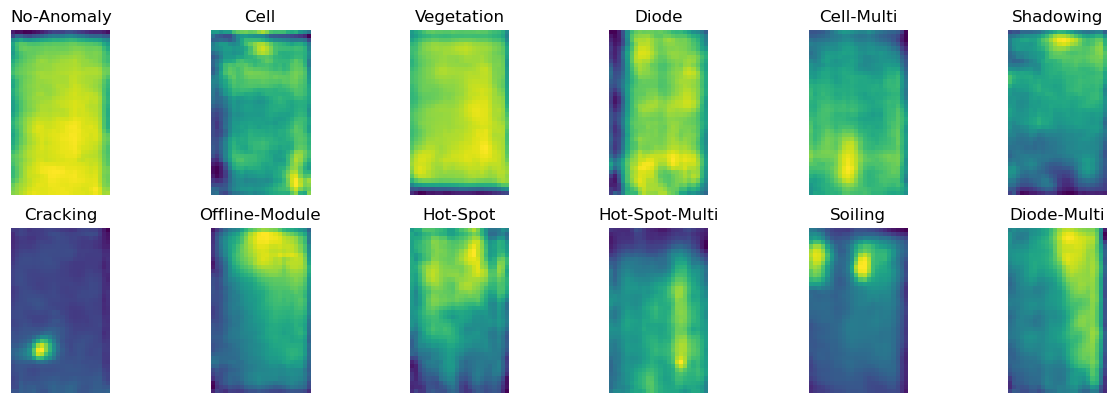

[Epoch 291/400] [D loss real: 0.48892535984516144, D loss fake: 0.4834898817539215] [G loss: 1.7442566227912903]
[Epoch 292/400] [D loss real: 0.4856784155964851, D loss fake: 0.4802252745628357] [G loss: 1.7802138447761535]
[Epoch 293/400] [D loss real: 0.48587968230247497, D loss fake: 0.47675156593322754] [G loss: 1.7540688574314118]
[Epoch 294/400] [D loss real: 0.4941967323422432, D loss fake: 0.4885759288072586] [G loss: 1.7353802061080932]
[Epoch 295/400] [D loss real: 0.48364359825849534, D loss fake: 0.47464441776275634] [G loss: 1.7120301574468613]
[Epoch 296/400] [D loss real: 0.500593078136444, D loss fake: 0.49378722190856933] [G loss: 1.7524342942237854]
[Epoch 297/400] [D loss real: 0.49284190744161605, D loss fake: 0.48636180251836775] [G loss: 1.7484157860279084]
[Epoch 298/400] [D loss real: 0.4876831042766571, D loss fake: 0.47528369426727296] [G loss: 1.710531027317047]
[Epoch 299/400] [D loss real: 0.49141016125679016, D loss fake: 0.4865529465675354] [G loss: 1.75

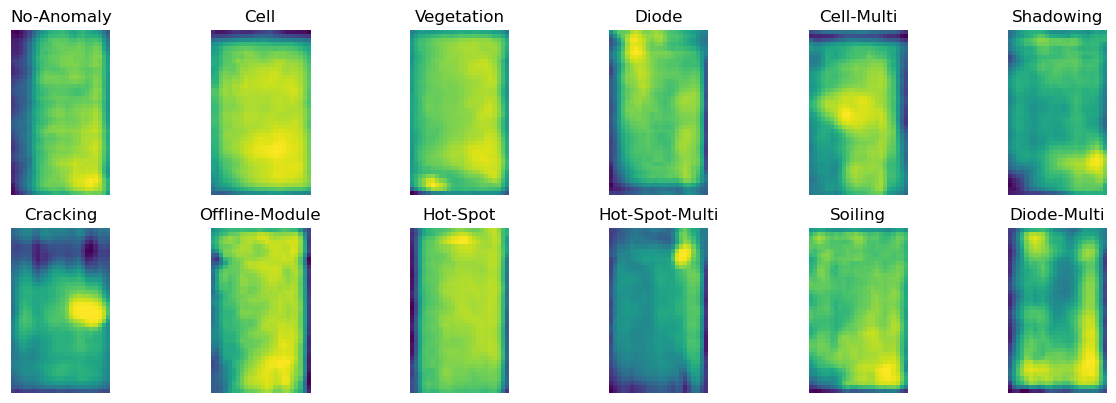

[Epoch 301/400] [D loss real: 0.4848817041516304, D loss fake: 0.47408254593610766] [G loss: 1.7435129076242446]
[Epoch 302/400] [D loss real: 0.48875306397676466, D loss fake: 0.4867864501476288] [G loss: 1.717042964696884]
[Epoch 303/400] [D loss real: 0.48113143652677537, D loss fake: 0.47320459663867953] [G loss: 1.7148485505580902]
[Epoch 304/400] [D loss real: 0.4919084936380386, D loss fake: 0.4849303686618805] [G loss: 1.8022192215919495]
[Epoch 305/400] [D loss real: 0.49699810236692427, D loss fake: 0.4923017019033432] [G loss: 1.8016447055339813]
[Epoch 306/400] [D loss real: 0.49921869933605195, D loss fake: 0.48956602066755295] [G loss: 1.7418570566177367]
[Epoch 307/400] [D loss real: 0.48964216709136965, D loss fake: 0.47452448278665543] [G loss: 1.7033431327342987]
[Epoch 308/400] [D loss real: 0.505825729072094, D loss fake: 0.4967771542072296] [G loss: 1.7789398205280305]
[Epoch 309/400] [D loss real: 0.49167975574731826, D loss fake: 0.4841622346639633] [G loss: 1.72

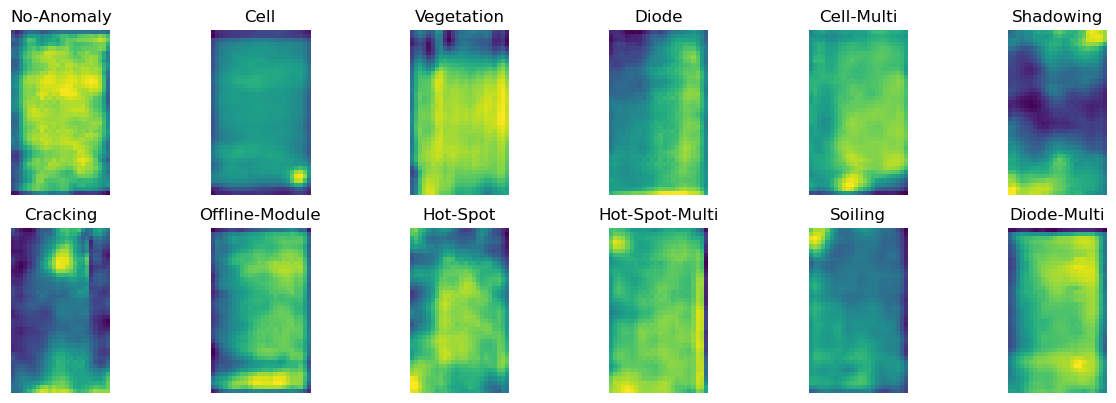

[Epoch 311/400] [D loss real: 0.48835007220506665, D loss fake: 0.47585003316402436] [G loss: 1.7809615695476533]
[Epoch 312/400] [D loss real: 0.4810939618945122, D loss fake: 0.47469969242811205] [G loss: 1.7745010733604432]
[Epoch 313/400] [D loss real: 0.48147615760564805, D loss fake: 0.4803912070393562] [G loss: 1.7490209281444549]
[Epoch 314/400] [D loss real: 0.49642218559980394, D loss fake: 0.491014264523983] [G loss: 1.737762296795845]
[Epoch 315/400] [D loss real: 0.49382380545139315, D loss fake: 0.48803730130195616] [G loss: 1.7603164803981781]
[Epoch 316/400] [D loss real: 0.49519899398088457, D loss fake: 0.48030497461557387] [G loss: 1.760875752568245]
[Epoch 317/400] [D loss real: 0.48253391414880753, D loss fake: 0.4798217263817787] [G loss: 1.7274255806207657]
[Epoch 318/400] [D loss real: 0.4896752825379372, D loss fake: 0.48007135778665544] [G loss: 1.71417010307312]
[Epoch 319/400] [D loss real: 0.48978219538927076, D loss fake: 0.4824693322181702] [G loss: 1.732

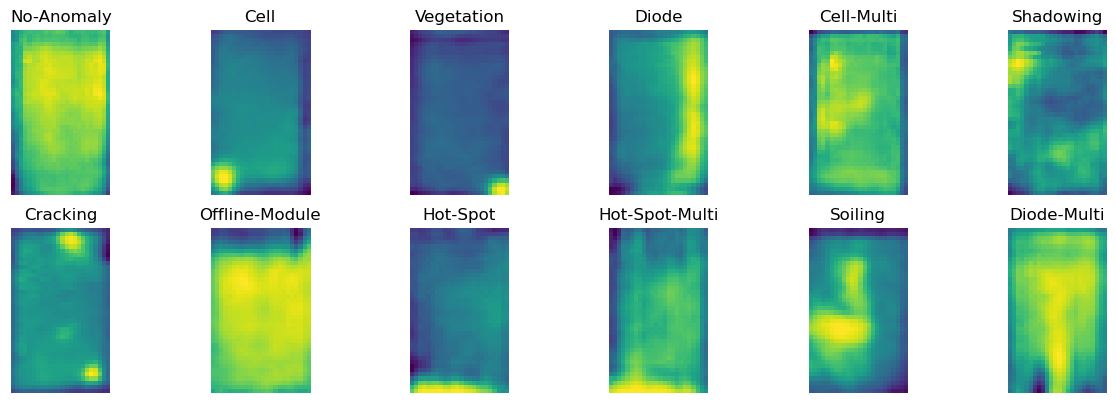

[Epoch 321/400] [D loss real: 0.48514467507600784, D loss fake: 0.4802928242087364] [G loss: 1.7709466600418091]
[Epoch 322/400] [D loss real: 0.47449138790369033, D loss fake: 0.4769466423988342] [G loss: 1.762625153064728]
[Epoch 323/400] [D loss real: 0.48193956226110457, D loss fake: 0.48193036019802094] [G loss: 1.766194384098053]
[Epoch 324/400] [D loss real: 0.4759647426009178, D loss fake: 0.47588860988616943] [G loss: 1.7400756347179414]
[Epoch 325/400] [D loss real: 0.480253689289093, D loss fake: 0.4810317143797874] [G loss: 1.754313895702362]
[Epoch 326/400] [D loss real: 0.4804685750603676, D loss fake: 0.4762759125232697] [G loss: 1.7823796153068543]
[Epoch 327/400] [D loss real: 0.47871611028909683, D loss fake: 0.48322633177042007] [G loss: 1.7956800746917725]
[Epoch 328/400] [D loss real: 0.48191307455301285, D loss fake: 0.483043869137764] [G loss: 1.7668823540210723]
[Epoch 329/400] [D loss real: 0.4707500648498535, D loss fake: 0.46690323799848554] [G loss: 1.766868

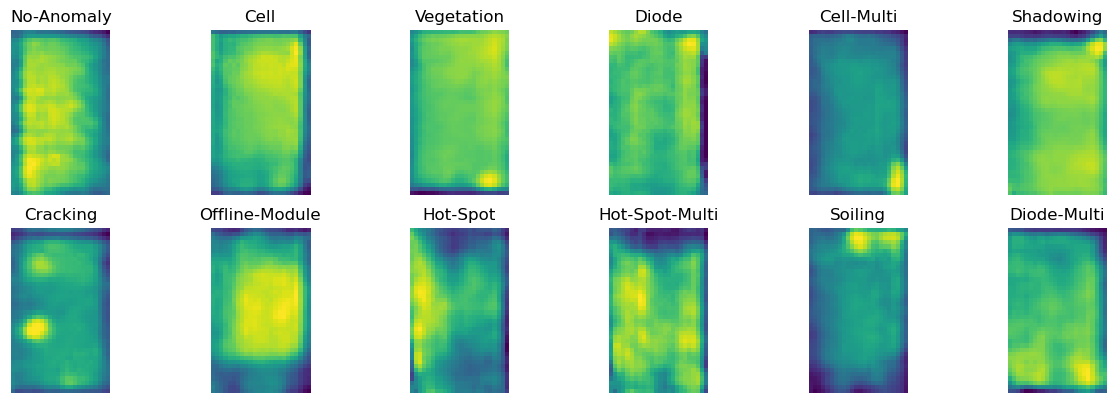

[Epoch 331/400] [D loss real: 0.48597472965717314, D loss fake: 0.4838289356231689] [G loss: 1.7718895357847213]
[Epoch 332/400] [D loss real: 0.4780439469218254, D loss fake: 0.47728117257356645] [G loss: 1.7691754043102264]
[Epoch 333/400] [D loss real: 0.4832795190811157, D loss fake: 0.4779897376894951] [G loss: 1.766640783548355]
[Epoch 334/400] [D loss real: 0.47457569628953933, D loss fake: 0.46840177744627] [G loss: 1.7837408936023713]
[Epoch 335/400] [D loss real: 0.47637340873479844, D loss fake: 0.47533450931310656] [G loss: 1.7840317738056184]
[Epoch 336/400] [D loss real: 0.48060142010450363, D loss fake: 0.471631860435009] [G loss: 1.7328754633665084]
[Epoch 337/400] [D loss real: 0.48027498036623, D loss fake: 0.4755349135398865] [G loss: 1.7995765066146852]
[Epoch 338/400] [D loss real: 0.4812066397070885, D loss fake: 0.4797860711812973] [G loss: 1.780694980621338]
[Epoch 339/400] [D loss real: 0.4847706040740013, D loss fake: 0.4762618038058281] [G loss: 1.74629384934

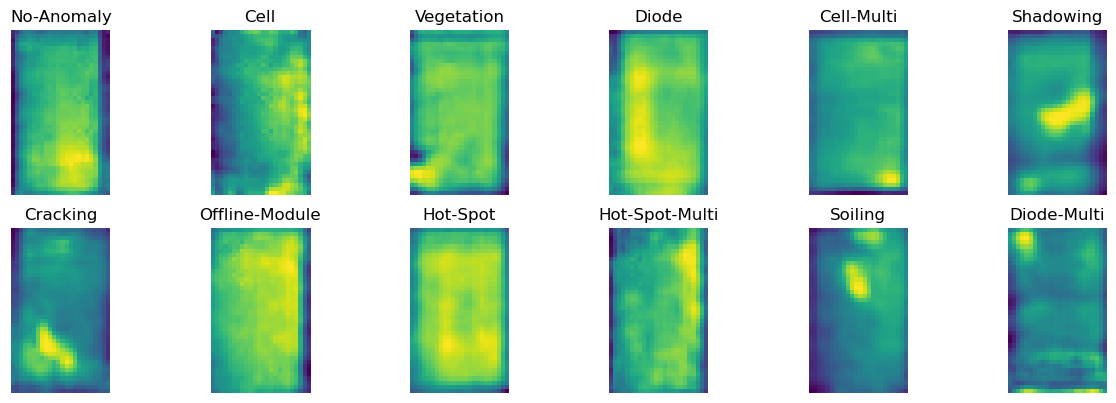

[Epoch 341/400] [D loss real: 0.47421530991792676, D loss fake: 0.47226657122373583] [G loss: 1.738482387661934]
[Epoch 342/400] [D loss real: 0.48477624386548995, D loss fake: 0.4798676228523254] [G loss: 1.7735930645465852]
[Epoch 343/400] [D loss real: 0.4779117316007614, D loss fake: 0.47230321407318115] [G loss: 1.7850858640670777]
[Epoch 344/400] [D loss real: 0.48078287452459334, D loss fake: 0.48238528311252593] [G loss: 1.7944327306747436]
[Epoch 345/400] [D loss real: 0.4861901694536209, D loss fake: 0.4770884203910828] [G loss: 1.732719271183014]
[Epoch 346/400] [D loss real: 0.4861693400144577, D loss fake: 0.47701800882816314] [G loss: 1.7603262734413148]
[Epoch 347/400] [D loss real: 0.48868160843849184, D loss fake: 0.47937810540199277] [G loss: 1.7716183972358703]
[Epoch 348/400] [D loss real: 0.4828796157240868, D loss fake: 0.4711558377742767] [G loss: 1.762718997001648]
[Epoch 349/400] [D loss real: 0.4857882073521614, D loss fake: 0.481867815554142] [G loss: 1.84017

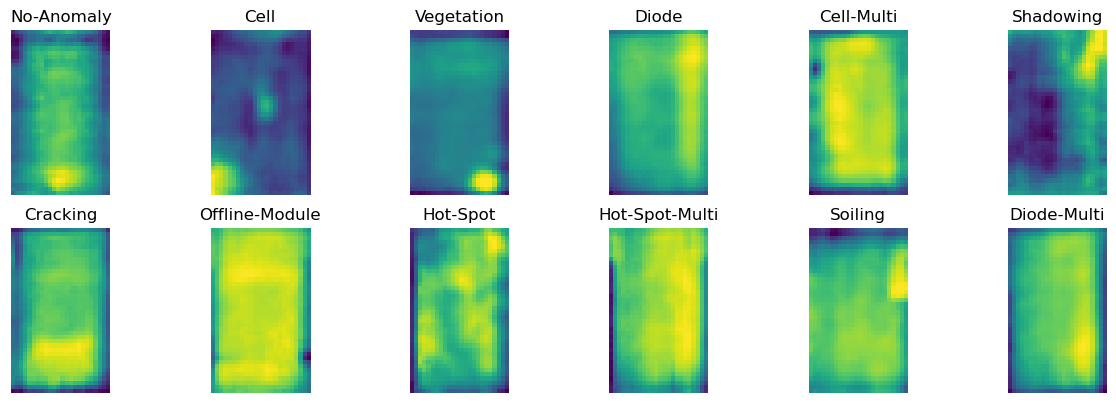

[Epoch 351/400] [D loss real: 0.473784901201725, D loss fake: 0.46634232968091965] [G loss: 1.7451037800312041]
[Epoch 352/400] [D loss real: 0.4874410831928253, D loss fake: 0.47202180862426757] [G loss: 1.7508922564983367]
[Epoch 353/400] [D loss real: 0.483702055811882, D loss fake: 0.474426728785038] [G loss: 1.7294383358955383]
[Epoch 354/400] [D loss real: 0.48705949395895004, D loss fake: 0.48266797184944155] [G loss: 1.7760419595241546]
[Epoch 355/400] [D loss real: 0.4838524803519249, D loss fake: 0.48446277260780335] [G loss: 1.8242088669538499]
[Epoch 356/400] [D loss real: 0.49591673254966734, D loss fake: 0.4790837377309799] [G loss: 1.7856558364629747]
[Epoch 357/400] [D loss real: 0.48677063435316087, D loss fake: 0.48315260738134386] [G loss: 1.7559575217962264]
[Epoch 358/400] [D loss real: 0.4810334554314613, D loss fake: 0.4786394739151001] [G loss: 1.7946636033058168]
[Epoch 359/400] [D loss real: 0.4682471549510956, D loss fake: 0.46975690335035325] [G loss: 1.7769

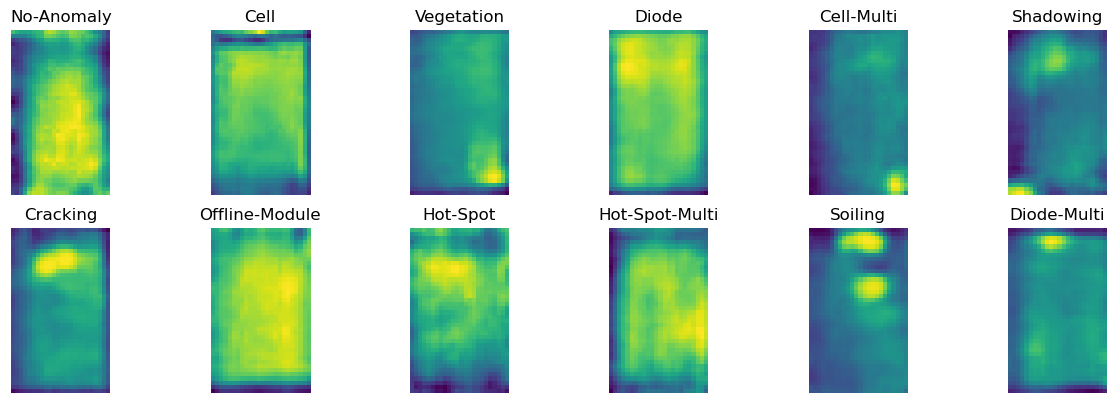

[Epoch 361/400] [D loss real: 0.4786046355962753, D loss fake: 0.47800086826086047] [G loss: 1.743705540895462]
[Epoch 362/400] [D loss real: 0.48715855568647387, D loss fake: 0.48111322611570356] [G loss: 1.7448737370967864]
[Epoch 363/400] [D loss real: 0.489589082300663, D loss fake: 0.47526762425899505] [G loss: 1.7877444112300873]
[Epoch 364/400] [D loss real: 0.4723884370923042, D loss fake: 0.4653702247142792] [G loss: 1.7606194829940796]
[Epoch 365/400] [D loss real: 0.474505235850811, D loss fake: 0.4736742782592773] [G loss: 1.762063844203949]
[Epoch 366/400] [D loss real: 0.4708684602379799, D loss fake: 0.46478471368551255] [G loss: 1.7390878093242645]
[Epoch 367/400] [D loss real: 0.47102454155683515, D loss fake: 0.474741085767746] [G loss: 1.8161283469200133]
[Epoch 368/400] [D loss real: 0.47994874745607374, D loss fake: 0.4697477999329567] [G loss: 1.7549558508396148]
[Epoch 369/400] [D loss real: 0.4772061467170715, D loss fake: 0.4744143533706665] [G loss: 1.78444451

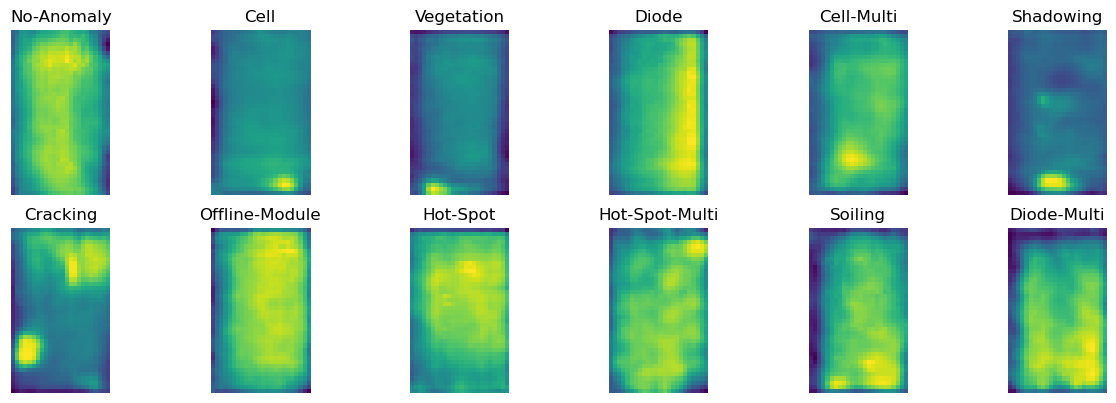

[Epoch 371/400] [D loss real: 0.4784712916612625, D loss fake: 0.4714415040612221] [G loss: 1.779377254843712]
[Epoch 372/400] [D loss real: 0.4708170902729034, D loss fake: 0.4742877355217934] [G loss: 1.787593547105789]
[Epoch 373/400] [D loss real: 0.4799477469921112, D loss fake: 0.4774107775092125] [G loss: 1.757759552001953]
[Epoch 374/400] [D loss real: 0.48860805183649064, D loss fake: 0.4819118568301201] [G loss: 1.7573079931735993]
[Epoch 375/400] [D loss real: 0.4813636767864227, D loss fake: 0.4698612728714943] [G loss: 1.763237891793251]
[Epoch 376/400] [D loss real: 0.47890821486711505, D loss fake: 0.48078165620565416] [G loss: 1.7879159861803056]
[Epoch 377/400] [D loss real: 0.4757222244143486, D loss fake: 0.4695249870419502] [G loss: 1.818576340675354]
[Epoch 378/400] [D loss real: 0.47309248328208925, D loss fake: 0.47243134051561353] [G loss: 1.8115219926834107]
[Epoch 379/400] [D loss real: 0.47181939989328386, D loss fake: 0.469388382434845] [G loss: 1.7895604997

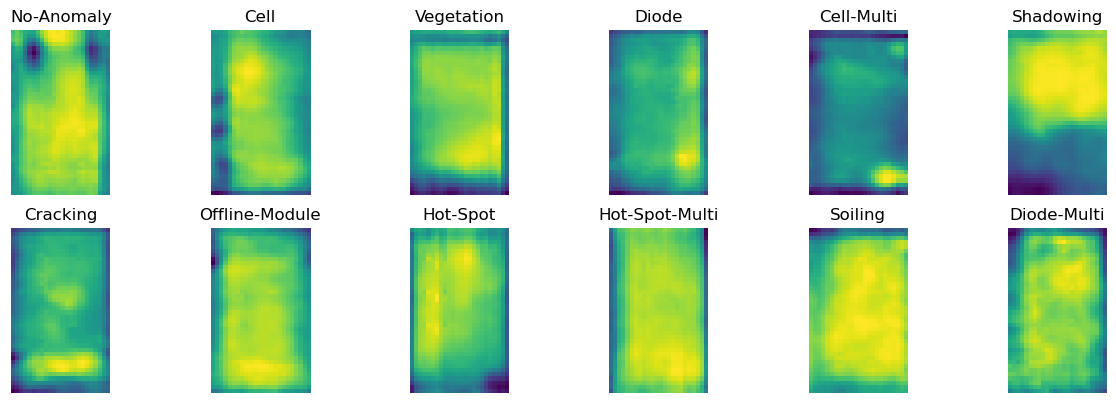

[Epoch 381/400] [D loss real: 0.4658322075009346, D loss fake: 0.4742087185382843] [G loss: 1.8173634469509126]
[Epoch 382/400] [D loss real: 0.47292286723852156, D loss fake: 0.4688332697749138] [G loss: 1.7504971253871917]
[Epoch 383/400] [D loss real: 0.4748385387659073, D loss fake: 0.4669923311471939] [G loss: 1.770968725681305]
[Epoch 384/400] [D loss real: 0.476335899233818, D loss fake: 0.46816640615463256] [G loss: 1.7440621042251587]
[Epoch 385/400] [D loss real: 0.4718639087677002, D loss fake: 0.46803477048873904] [G loss: 1.7720536386966705]
[Epoch 386/400] [D loss real: 0.46544949114322665, D loss fake: 0.46361965358257295] [G loss: 1.7603983533382417]
[Epoch 387/400] [D loss real: 0.46820195436477663, D loss fake: 0.4706304973363876] [G loss: 1.7913184797763824]
[Epoch 388/400] [D loss real: 0.47828489661216733, D loss fake: 0.47650068134069445] [G loss: 1.7983997559547424]
[Epoch 389/400] [D loss real: 0.47543322503566743, D loss fake: 0.47077582895755765] [G loss: 1.77

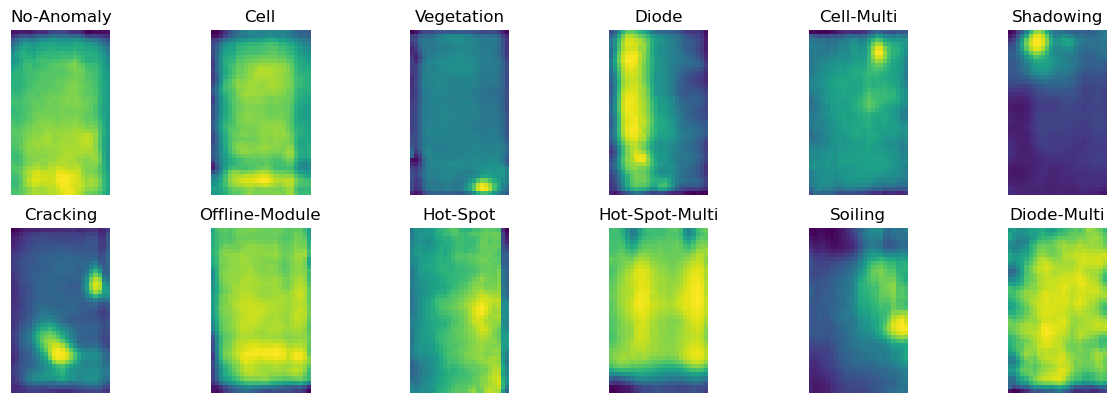

[Epoch 391/400] [D loss real: 0.4663235893845558, D loss fake: 0.47028177589178083] [G loss: 1.8102742838859558]
[Epoch 392/400] [D loss real: 0.4709045407176018, D loss fake: 0.46312677502632144] [G loss: 1.8024861848354339]
[Epoch 393/400] [D loss real: 0.47585232138633726, D loss fake: 0.4666814714670181] [G loss: 1.7728942775726317]
[Epoch 394/400] [D loss real: 0.47101635605096814, D loss fake: 0.46611854046583173] [G loss: 1.7771953284740447]
[Epoch 395/400] [D loss real: 0.4663941794633865, D loss fake: 0.4616257557272911] [G loss: 1.749658864736557]
[Epoch 396/400] [D loss real: 0.47207077622413635, D loss fake: 0.4712613567709923] [G loss: 1.8283457607030869]
[Epoch 397/400] [D loss real: 0.4694880670309067, D loss fake: 0.46695128351449966] [G loss: 1.7748866963386536]
[Epoch 398/400] [D loss real: 0.47135725766420367, D loss fake: 0.47255865186452867] [G loss: 1.8011509490013122]
[Epoch 399/400] [D loss real: 0.46842271625995635, D loss fake: 0.4668047747015953] [G loss: 1.7

In [32]:
fit_total_loss_gen, fit_total_loss_disc = g_model.fit(g_train_test.train_dataloader, epochs=400)

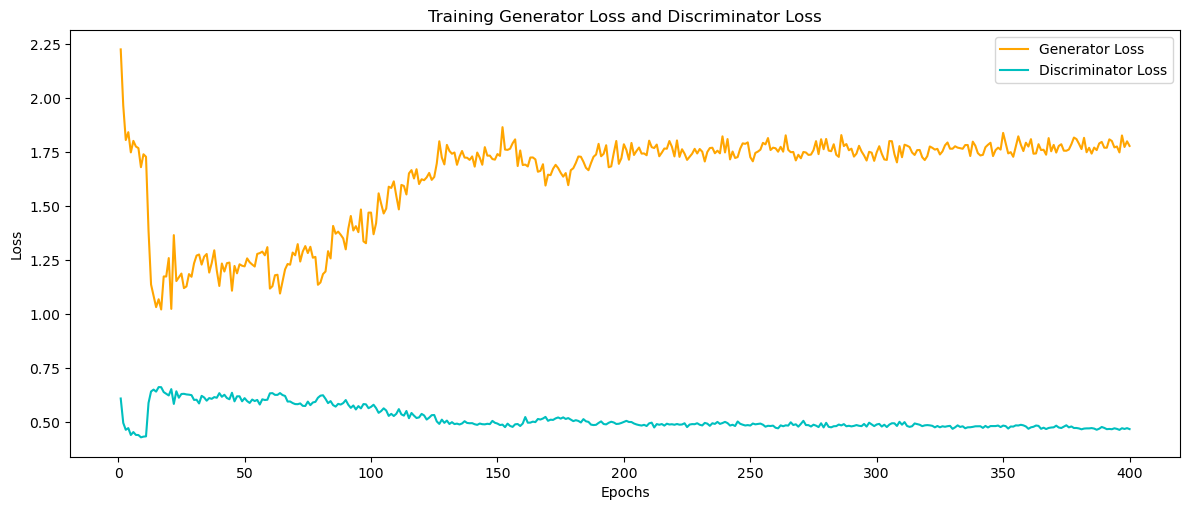

In [33]:
# Plot the loss and accuracy curves
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

axs.plot(range(1, len(fit_total_loss_gen) + 1), fit_total_loss_gen, color='orange', label="Generator Loss")
axs.plot(range(1, len(fit_total_loss_disc) + 1), fit_total_loss_disc, color='c', label="Discriminator Loss")
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()

plt.tight_layout()  # ensure the two axes are on the same scale
plt.title('Training Generator Loss and Discriminator Loss')
plt.show()

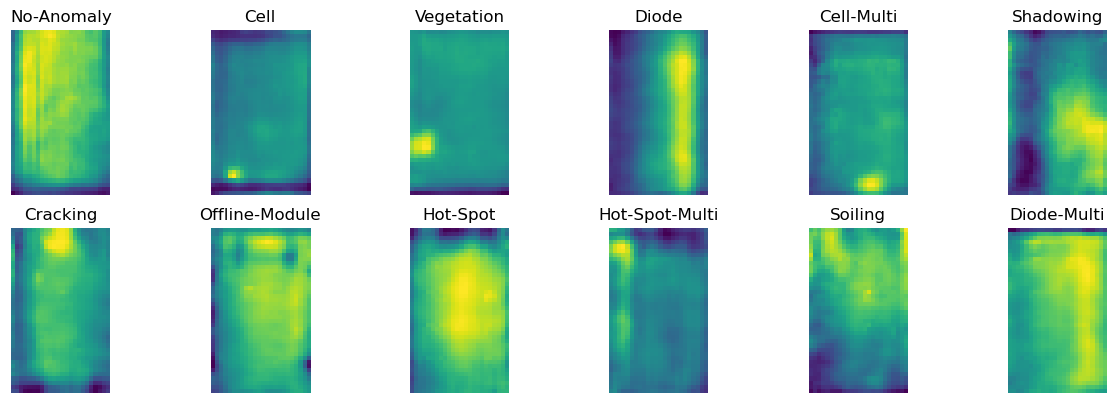

In [ ]:
plt.figure(figsize=(15,15))
for j in range(solar_dataset.num_classes):
    image = g_model.augment(1, j)[0].cpu().numpy()
    plt.subplot(6, 6, j+1)
    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
    plt.title(solar_dataset.classes_list[j])
    plt.axis('off')
plt.show()

In [35]:
def preprocess_gan_augment(image, aug_number, label):
    image_list = []

    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define transforms list
    transforms_list = [
        transforms.Compose([
            transforms.RandomApply(transforms=[
                transforms.RandomHorizontalFlip(p=0.30),
                transforms.RandomVerticalFlip(p=0.30),
            ]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            if np.random.rand() <= 0.50:
                img_aug = g_model.augment(1, solar_dataset.classes_list.index(label))
                for im in img_aug:
                    image_list.append(im.cpu().numpy())
            else:
                image_list.append(transforms_list[0](Image.fromarray(image)).numpy())
    return image_list

In [36]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_gan = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_gan, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_gan = nn.CrossEntropyLoss().to(device)
our_optimizer_gan = Adam(our_model_gan.parameters(), lr=0.000127)
our_train_test_gan = utils.TrainTest(
    our_model_gan,
    our_loss_gan,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_gan_augment,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 25, 39, 23]           425
│    └─BatchNorm2d: 2-2                  [1, 25, 39, 23]           50
│    └─ReLU: 2-3                         [1, 25, 39, 23]           --
│    └─Dropout: 2-4                      [1, 25, 39, 23]           --
│    └─Conv2d: 2-5                       [1, 50, 38, 22]           20,050
│    └─BatchNorm2d: 2-6                  [1, 50, 38, 22]           100
│    └─ReLU: 2-7                         [1, 50, 38, 22]           --
│    └─AvgPool2d: 2-8                    [1, 50, 19, 11]           --
│    └─Dropout: 2-9                      [1, 50, 19, 11]           --
│    └─Conv2d: 2-10                      [1, 75, 19, 11]           33,825
│    └─BatchNorm2d: 2-11                 [1, 75, 19, 11]           150
│   

Loss = 2.0410421500130305   Accuracy= 0.5746527777777778
Best Epoch # 0  Validation Loss= 2.0410421500130305  Validation Accu= 0.5746527777777778
Loss = 1.9747170588326832   Accuracy= 0.6413690476190477
Best Epoch # 1  Validation Loss= 1.9747170588326832  Validation Accu= 0.6413690476190477
Loss = 1.9553153798693703   Accuracy= 0.6631944444444444
Best Epoch # 2  Validation Loss= 1.9553153798693703  Validation Accu= 0.6631944444444444
Loss = 1.9512064173108055   Accuracy= 0.6634424603174603
Best Epoch # 3  Validation Loss= 1.9512064173108055  Validation Accu= 0.6634424603174603
Loss = 1.93031026257409   Accuracy= 0.6872519841269841
Best Epoch # 4  Validation Loss= 1.93031026257409  Validation Accu= 0.6872519841269841
Loss = 1.9265761451115684   Accuracy= 0.689484126984127
Best Epoch # 5  Validation Loss= 1.9265761451115684  Validation Accu= 0.689484126984127
Loss = 1.9122839182142228   Accuracy= 0.7043650793650794
Best Epoch # 6  Validation Loss= 1.9122839182142228  Validation Accu= 0.7

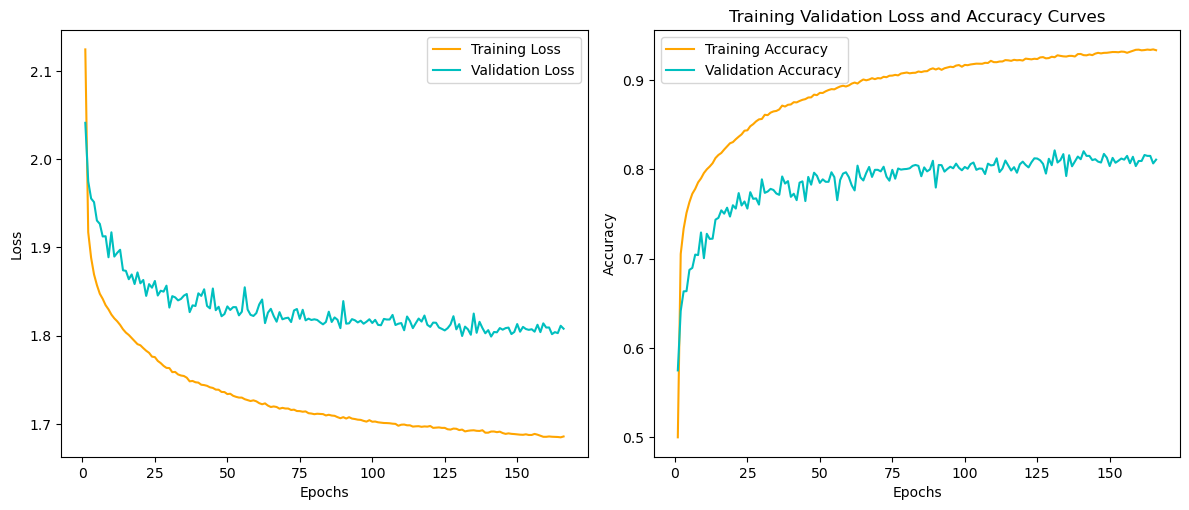

In [37]:
# Train Model
our_best_gan_loss, our_best_gan_accuracy, our_best_gan_epoch = our_train_test_gan.train(our_optimizer_gan, 166, "our_model_gan_aug.pth")

In [39]:
our_train_test_gan.loadModel('our_model_gan_aug.pth') # Load best model

Loss = 1.7994785800812736   Accuracy= 0.8211805555555556


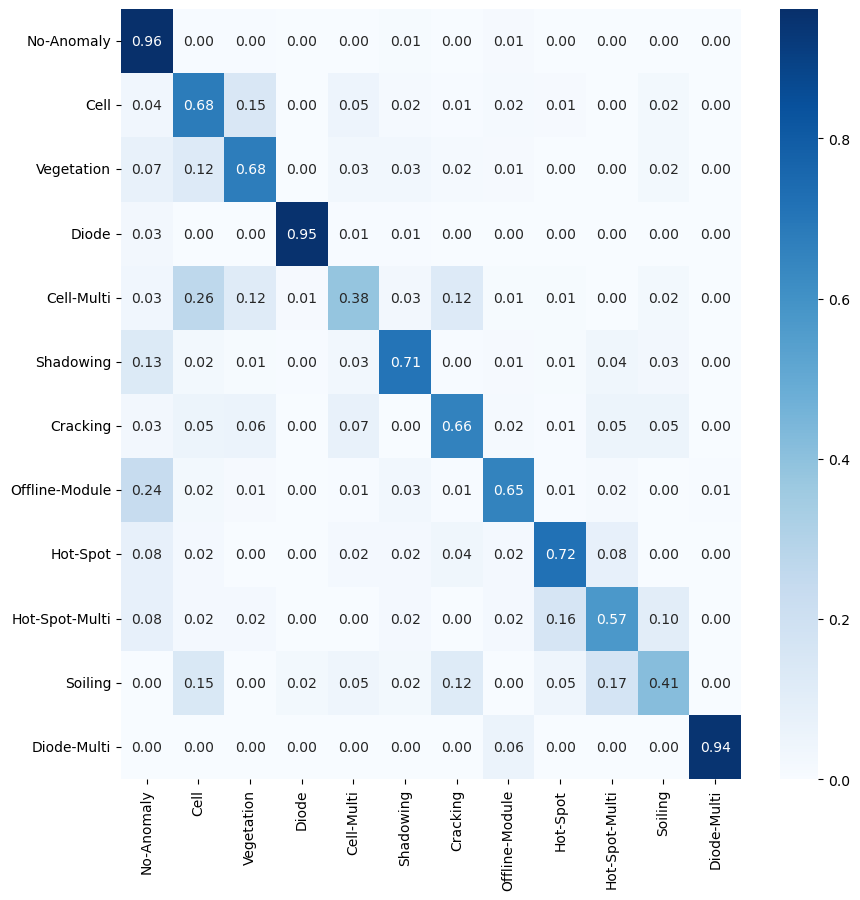

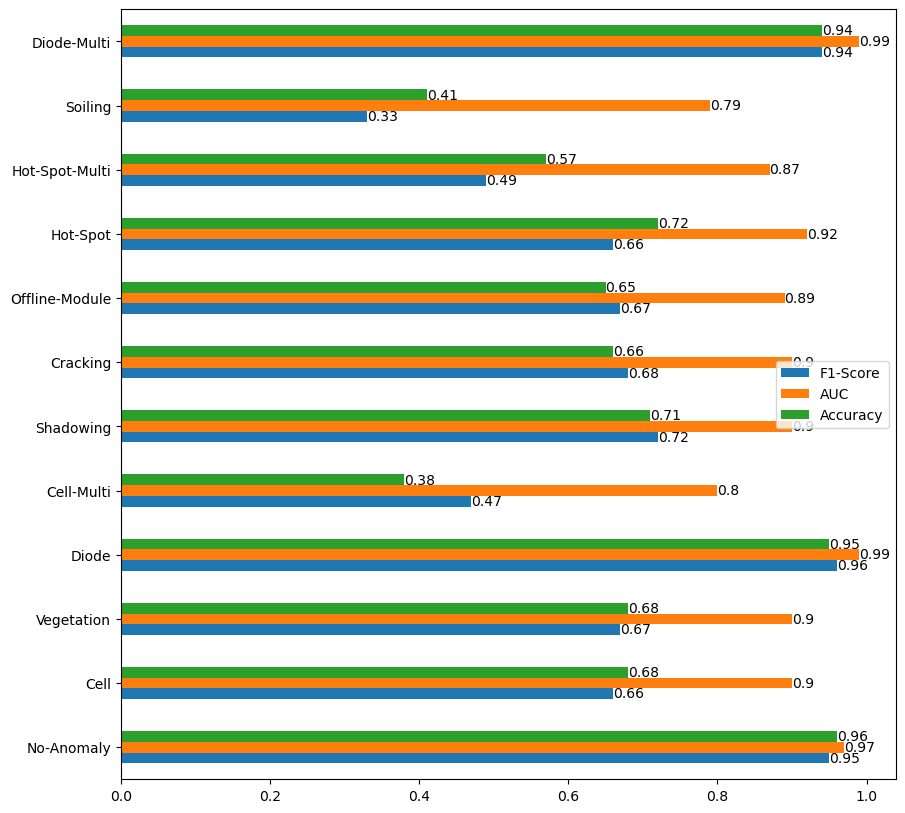

In [40]:
our_train_test_gan.test()
our_train_test_gan.plot_confusion_matrix()
our_train_test_gan.plot_class_metrics()

---

# Pre-Trained Models

In computer vision, transfer learning is commonly used with convolutional neural networks (CNNs) pre-trained on large image datasets like ImageNet. These pre-trained models can be used as a fixed feature extractor for tasks such as object detection, image segmentation, and image classification.

After running our models we decided to use pre trained models:


*   MobileNet v2
*   Visual Transformers
<br><br>

The use of pre trained models in deep learning has some advantages such as:

**Reducing the training time** - since this models are already trained on large and diverse datasets like ImageNet they've learned rich feature representations.

**Less Labeled Data Required** -  they can perform well with smaller amounts of labeled data for the target task. This is crucial in scenarios where collecting large labeled datasets is time-consuming or expensive.

**Resource Savings**: Training deep neural networks from scratch requires significant computational resources. By using pre-trained models, we can save time, computing power, and energy consumption.

**Feature Retention through Freezing**: One of the key steps in transfer learning is the ability to freeze the layers of the pre-trained model so that only some portions of the network are updated during training. Freezing is crucial to maintain the features that the pre-trained model has already learned.

<br><br>

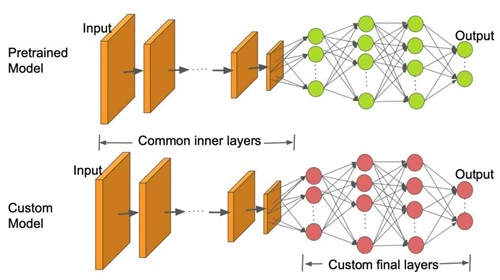

<br><br>

The image above ilustrates well one of the keys points for using pre-trained models in this project. The possibility of changeing the existing archisture of the model - we can freeze most of the parameters and use/change the others. Unfreezing a layer means that the weights and biases of that layer will be updated during the training process.



## MobileNetV2

In [214]:
def preprocess_mobile(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [215]:
input_dim = (3, 40, 24)

model_mobile = torchvision.models.mobilenet_v2(pretrained=True)
for i, param in enumerate(model_mobile.parameters()):
    param.requires_grad = False

num_features = model_mobile.classifier[1].in_features
model_mobile.classifier[1] = nn.Sequential(
    nn.Linear(num_features, 800),
    nn.ReLU(),
    nn.Dropout(0.50),
    nn.Linear(800, 500),
    nn.ReLU(),
    nn.Linear(500, 12),
)

print(summary(model_mobile.to(device), (1, input_dim[0], input_dim[1], input_dim[2])))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 12]                   --
├─Sequential: 1-1                                  [1, 1280, 2, 1]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 20, 12]           --
│    │    └─Conv2d: 3-1                            [1, 32, 20, 12]           (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 20, 12]           (64)
│    │    └─ReLU6: 3-3                             [1, 32, 20, 12]           --
│    └─InvertedResidual: 2-2                       [1, 16, 20, 12]           --
│    │    └─Sequential: 3-4                        [1, 16, 20, 12]           (896)
│    └─InvertedResidual: 2-3                       [1, 24, 10, 6]            --
│    │    └─Sequential: 3-5                        [1, 24, 10, 6]            (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 10, 6]            --
│    │    └─Sequential

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [216]:
loss_mobile = nn.BCEWithLogitsLoss().to(device)
optimizer_mobile = torch.optim.Adam(model_mobile.parameters(), lr=0.00025)
train_test_mobile = utils.TrainTest(
    model_mobile.to(device),
    loss_mobile,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_mobile,
    augment=False,
)

Loss = 0.20146672717399067   Accuracy= 0.5267857142857143
Best Epoch # 0  Validation Loss= 0.20146672717399067  Validation Accu= 0.5267857142857143
Loss = 0.18703640666272905   Accuracy= 0.5471230158730159
Best Epoch # 1  Validation Loss= 0.18703640666272905  Validation Accu= 0.5471230158730159
Loss = 0.18220784775321447   Accuracy= 0.5600198412698413
Best Epoch # 2  Validation Loss= 0.18220784775321447  Validation Accu= 0.5600198412698413
Loss = 0.1793098556143897   Accuracy= 0.5677083333333334
Best Epoch # 3  Validation Loss= 0.1793098556143897  Validation Accu= 0.5677083333333334
Loss = 0.17672560038784194   Accuracy= 0.5714285714285714
Best Epoch # 4  Validation Loss= 0.17672560038784194  Validation Accu= 0.5714285714285714
Loss = 0.17578009521913907   Accuracy= 0.574156746031746
Best Epoch # 5  Validation Loss= 0.17578009521913907  Validation Accu= 0.574156746031746
Loss = 0.17226305846420545   Accuracy= 0.5798611111111112
Best Epoch # 6  Validation Loss= 0.17226305846420545  Vali

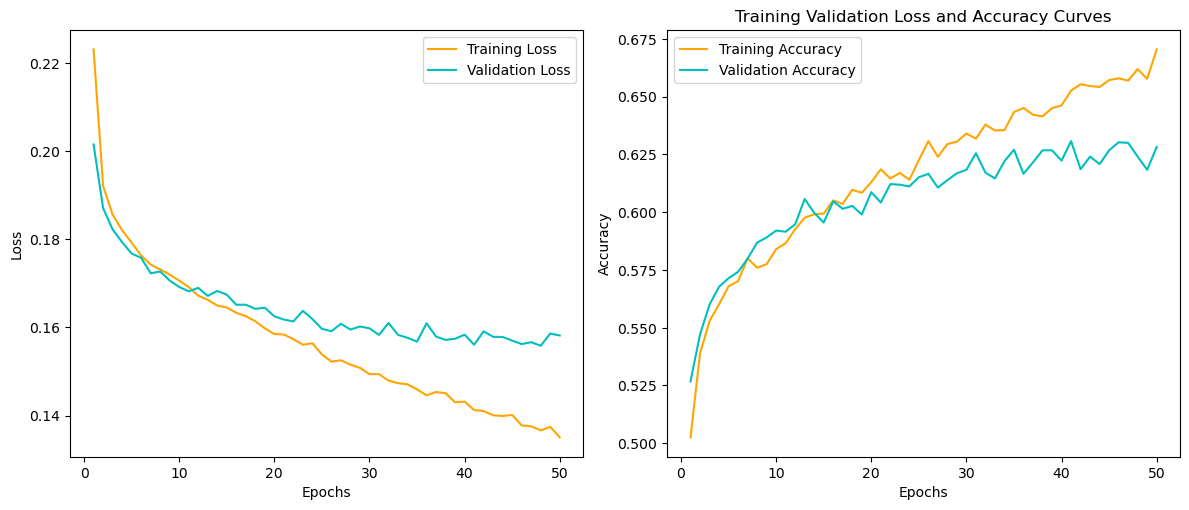

In [217]:
# Train Model
our_best_mobile_loss, our_best_mobile_accuracy, our_best_mobile_epoch = train_test_mobile.train(optimizer_mobile, 50, "mobile_model.pth")

Loss = 0.15815746636381225   Accuracy= 0.6282242063492064


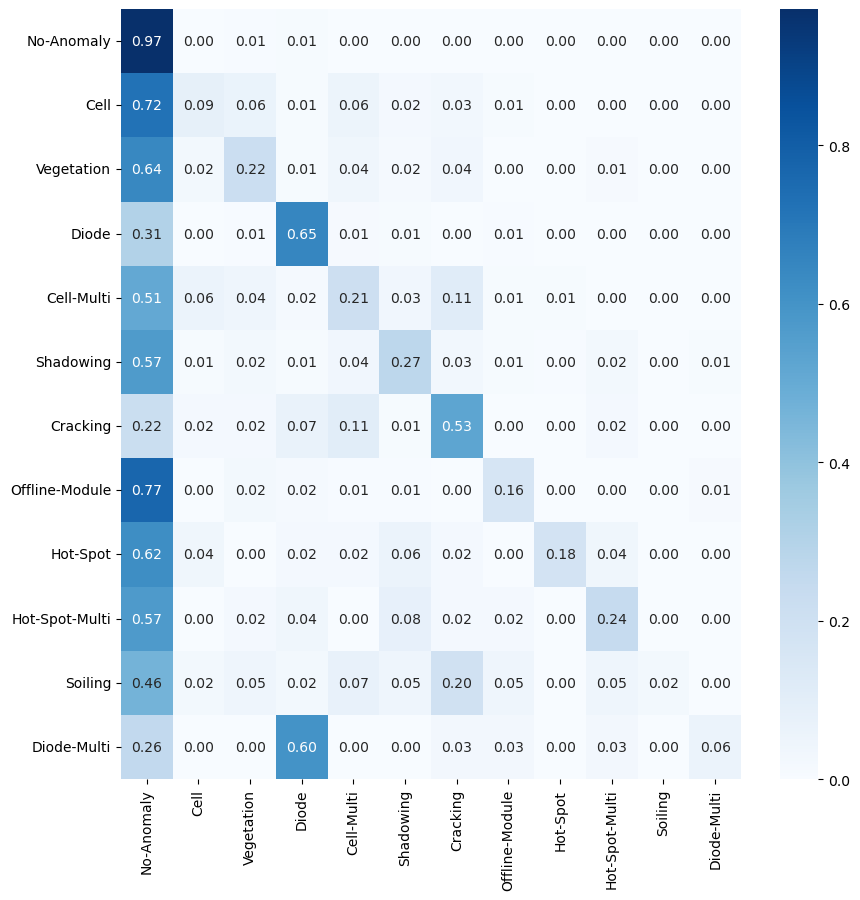

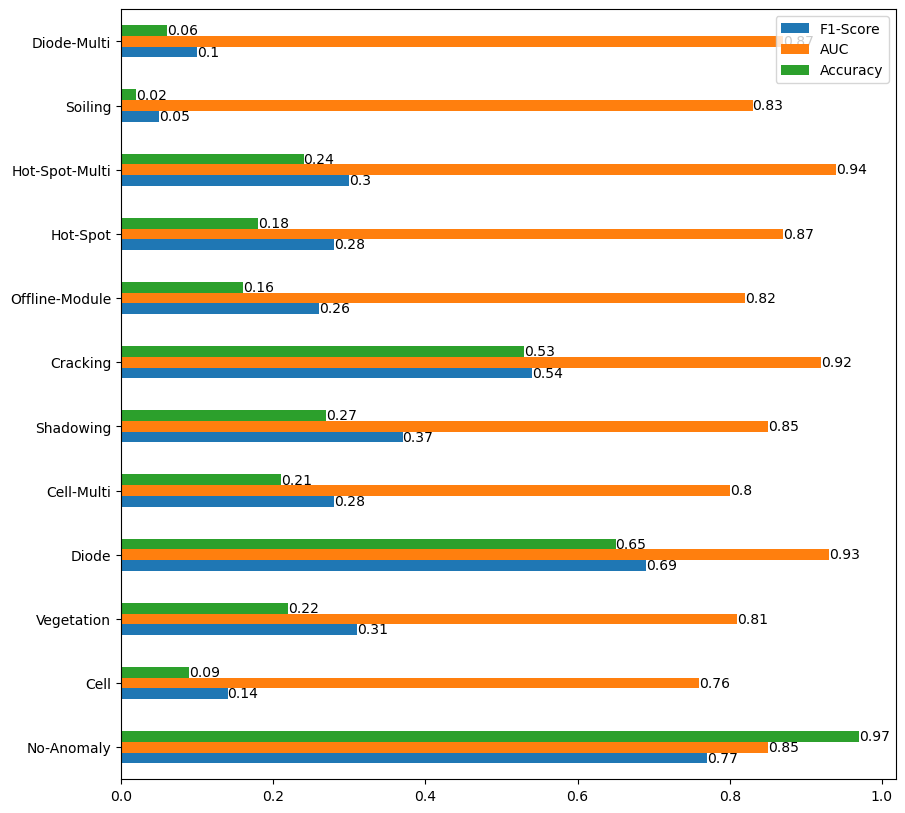

In [218]:
train_test_mobile.test()
train_test_mobile.plot_confusion_matrix()
train_test_mobile.plot_class_metrics()

## Pretrained Transformer

In [220]:
def preprocess_vit(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [222]:
input_dim = (3, 224, 224)
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights=weights_vit)
for p in model_vit.parameters():
    p.requires_grad = False

heads_vit = nn.Sequential(
    nn.Linear(768, 800),
    nn.ReLU(),
    nn.Dropout(0.50),
    nn.Linear(800, 500),
    nn.ReLU(),
    nn.Linear(500, 12),
)
model_vit.heads = heads_vit

summary(model_vit, input_size=(1, input_dim[0], input_dim[1], input_dim[2]))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 12]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [223]:
loss_vit = nn.BCEWithLogitsLoss().to(device)
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=0.0001)
train_test_vit = utils.TrainTest(
    model_vit.to(device),
    loss_vit,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_vit,
    augment=False,
)

Loss = 0.16979687610268593   Accuracy= 0.58925
Best Epoch # 0  Validation Loss= 0.16979687610268593  Validation Accu= 0.58925
Loss = 0.15589856925606727   Accuracy= 0.6175
Best Epoch # 1  Validation Loss= 0.15589856925606727  Validation Accu= 0.6175
Loss = 0.14555183163285254   Accuracy= 0.66525
Best Epoch # 2  Validation Loss= 0.14555183163285254  Validation Accu= 0.66525
Loss = 0.1386986622810364   Accuracy= 0.67325
Best Epoch # 3  Validation Loss= 0.1386986622810364  Validation Accu= 0.67325
Loss = 0.13465819495916367   Accuracy= 0.686
Best Epoch # 4  Validation Loss= 0.13465819495916367  Validation Accu= 0.686
Loss = 0.13145291398465633   Accuracy= 0.68875
Best Epoch # 5  Validation Loss= 0.13145291398465633  Validation Accu= 0.68875
Loss = 0.13141861748695374   Accuracy= 0.69725
Best Epoch # 6  Validation Loss= 0.13141861748695374  Validation Accu= 0.69725
Loss = 0.12603077322244643   Accuracy= 0.70175
Best Epoch # 7  Validation Loss= 0.12603077322244643  Validation Accu= 0.70175


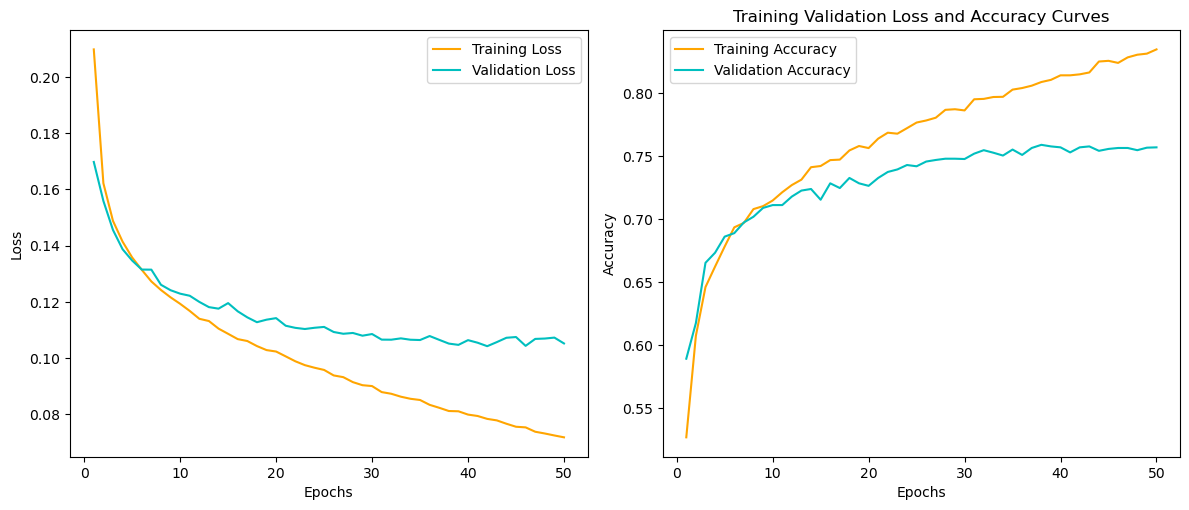

In [224]:
# Train Model
our_best_vit_loss, our_best_vit_accuracy, our_best_vit_epoch = train_test_vit.train(optimizer_vit, 50, "resnet_model_vit.pth")

Loss = 0.10512684205919504   Accuracy= 0.75675


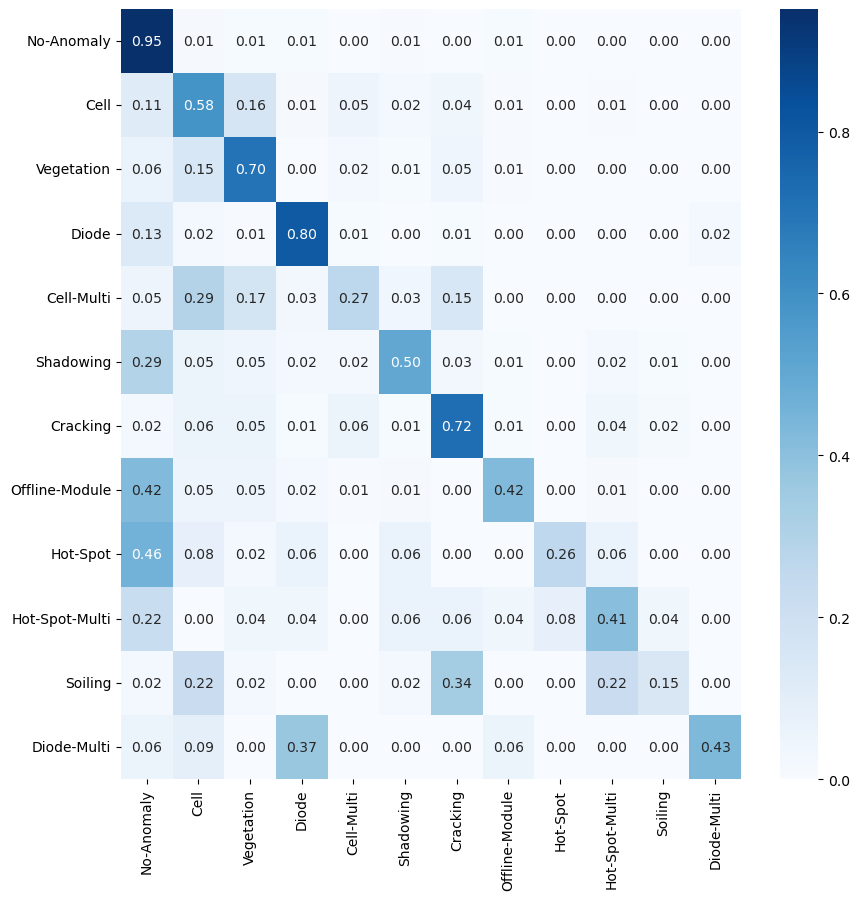

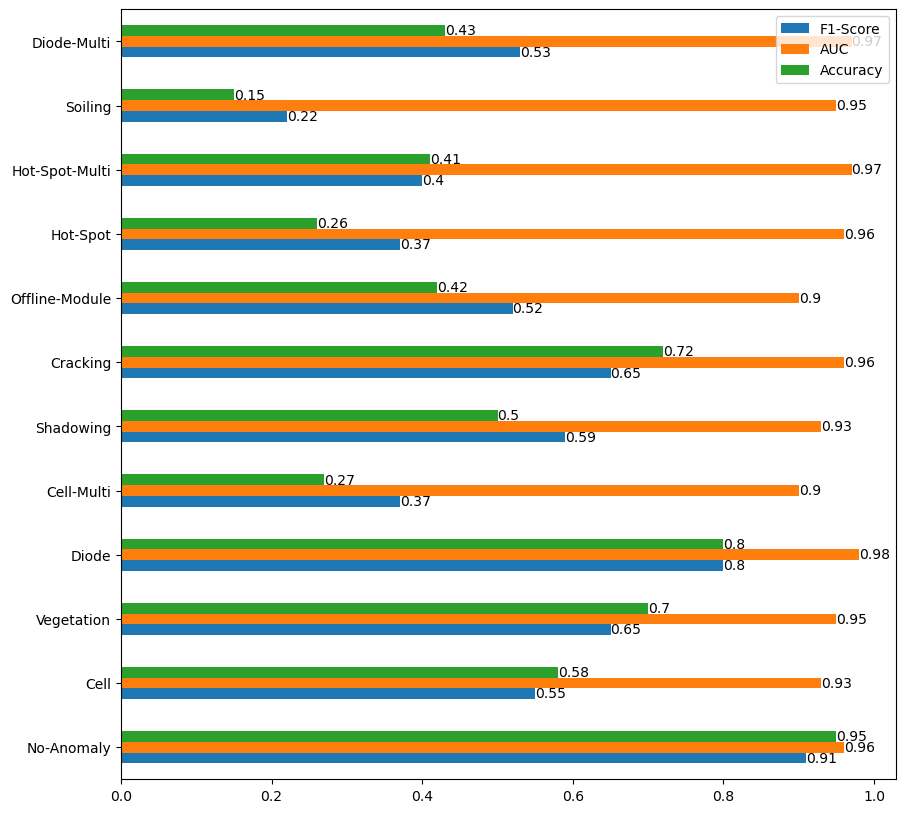

In [225]:
train_test_vit.test()
train_test_vit.plot_confusion_matrix()
train_test_vit.plot_class_metrics()

# Results and discussion

| Type | # Params | Acc Train | Acc Test |
| ---- | -------- | --------- | -------- |
| CNN from Paper (no data aug.) | 2.757.868 | 0.95 | 0.79 |
| Our CNN (no data aug.) | 998.162 | 0.79 | 0.74 |
| Class Sensitive (no data aug.) | 998.162 | 0.70 | 0.72 |
| Traditional data aug. | 998.162 | 0.90 | 0.81 |
| Traditional (50%) + GAN data aug. (50%) | 998.162 | 0.95 | 0.82 |
| MobileNet v2 | 3.655.484 | 0.65 | 0.63 |
| Transformer | 86.820.368 | 0.85 | 0.76 |
| Original Paper | 2.760.268 | 0.92 | 0.85 |

# Conclusions


The comprehensive exploration and analysis of various models, pre-processing techniques, and fine-tuning strategies presented in this study aimed to address the challenges posed by a highly unbalanced dataset in the context of anomaly detection in solar panel images.
As can be seen, we used several models, quite diverse, where we also introduced some pre-processing techniques, tested through different neural networks and pre-trained models where we fine tuned them to obtain the best possible results.
The fact that we had a very unbalanced dataset had a strong impact on our work. Data balancing techniques were needed to obtain the best results, but they required a great deal of computational effort, as was the case with GAN (generative adversarial networks).
The images classified as Diode-Multi, Hot-Spot, Hot-Spot-Multi and soiling were always the most difficult to train, but ultimately we have succeeded in identifying these types of image.
The results of the paper served as a basis for us to set objectives and at the same time understand what were good and bad values for our evaluation metrics. The best results were the detection of No Anomaly (98%) and Diode (95%) and, on the negative side, the predicted anomalies were around 50% or lower Cell-Multi (51%), Hot-Spot-Multi (59%) and Soiling (37%).
When comparing the results, we concluded that the model with 60% oversample + 40% generative adversarial networks was the one that obtained the most positive results, with a test accuracy of 81.15%, with very good results in the classification of Diode-Multi (86%), Diode (92%) and No Anomaly (97%), while the anomalies Soiling (27%) and Cell-Multi (40%) were a real challenge. Overall, we consider this model to be more successful on average than the benchmark paper.
Among the models used, the one that ended up with the worst performance was the one fulfilling condition B (adding class sensitive learning), as well as having the lowest accuracy (77%), it also showed poor results in classifying the four anomalies Soiling (12%), Hot-Spot-Multi (35%), Cell-Multi (32%) and Hot-Spot (36%), this model shows a tremendous failure in detecting these classifications and its false predictions are directed towards No Anomaly, for example in the confusion matrix we see that 52% of the Hot-Spot errors are due to having classified it as No-Anomaly.
Regarding the pre-trained models, there was an higher expectation of their performance, even without updating all their wights - most of the blocks were freezed due to the lack of computational resources. For so well knowned models, having an accuracy of 63% in test was disappointing, however we believe that we can optimized ResNet and MobileNet, but specially the first one, and have better performace.
Unlike the pre-trained models, the expectation for the visual transformer(VIT) wasnt so high since usually good CNN architectures can perform better than the VIT. Although, VIT has an accuracy in test of 76% most of this good performance is due to the classes with more samples (as all of the other pre-trained) failling completly with the classes with less samples (it was prediction No Anomaly instead).

# References

https://www.sciencedirect.com/science/article/pii/S0263224123006991?via%3Dihub

https://openaccess.thecvf.com/content/CVPR2021/papers/Li_On_Feature_Normalization_and_Data_Augmentation_CVPR_2021_paper.pdf

https://arxiv.org/abs/2103.15158

https://arxiv.org/pdf/2010.11929.

https://www.frontiersin.org/articles/10.3389/fdata.2021.659146/full

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8253599

https://www.sciencedirect.com/science/article/abs/pii/S0957417417306346

https://www.foldl.me/uploads/2015/conditional-gans-face-generation/paper.

https://github.com/soumith/

https://arxiv.org/pdf/1511.06434.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0957417417306346